## Códigos práctica 5 para llegar a práctica 6: Featur Scaling...

In [1]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
import os
warnings.filterwarnings('ignore')

print("✅ Todas las librerías importadas correctamente")

# 3. Configurar visualizaciones
plt.style.use('seaborn-v0_8')  # estilo visual (ej: 'seaborn-v0_8', 'default', 'classic')
sns.set_palette("Set1")  # paleta de colores (ej: 'husl', 'Set1', 'viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🎨 Configuración de visualizaciones lista!")

✅ Todas las librerías importadas correctamente
🎨 Configuración de visualizaciones lista!


In [2]:
# === CARGAR DATASET AMES HOUSING ===

# 1. Cargar dataset base
df = pd.read_csv('../AmesHousing.csv')

print("🏠 DATASET: Ames Housing")
print(f"   📊 Forma original: {df.shape}")
print(f"   📋 Columnas: {list(df.columns)}")

# 2. Crear missing data sintético para práctica
np.random.seed(42)  # para reproducibilidad

# Simular MCAR en Year Built (8% missing aleatorio)
# "Los valores faltan al azar: que falte un Year Built no depende de la edad ni del propio Year Built"
missing_year = np.random.random(len(df)) < 0.08
df.loc[missing_year, 'Year Built'] = np.nan

# Simular MAR en Garage Area (missing relacionado con Garage Type)
# "Los faltantes de Garage Area se concentran en ciertos tipos de garaje (variable observada)"
df.loc[df['Garage Type'] == 'None', 'Garage Area'] = df.loc[df['Garage Type'] == 'None', 'Garage Area'].sample(frac=0.7, random_state=42)

# Simular MNAR en SalePrice (missing relacionado con precio alto)
# "Los faltantes dependen del propio valor: quienes tienen precios altos no reportan precio"
high_price = df['SalePrice'] > df['SalePrice'].quantile(0.85)
df.loc[high_price, 'SalePrice'] = df.loc[high_price, 'SalePrice'].sample(frac=0.2, random_state=42)

print("\n🔍 Missing data sintético creado:")
print(df.isnull().sum())  # método para contar valores faltantes por columna

🏠 DATASET: Ames Housing
   📊 Forma original: (2930, 82)
   📋 Columnas: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 

In [3]:
# === EXPLORACIÓN BÁSICA ===

# 1. Información general del dataset
print("=== INFORMACIÓN GENERAL ===")
print(df.info())  # método que muestra tipos de datos, memoria y valores no nulos

# 2. Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())  # método que calcula estadísticas descriptivas

# 3. Tipos de datos
print("\n=== TIPOS DE DATOS ===")
print(df.dtypes)  # atributo que muestra tipos de datos por columna

# 4. Verificar missing data
print("\n=== MISSING DATA POR COLUMNA ===")
missing_count = df.isnull().sum()  # contar valores faltantes
missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_pct
})
print(missing_stats[missing_stats['Missing_Count'] > 0])

# 5. Análisis de memoria
print("\n=== ANÁLISIS DE MEMORIA ===")
total_bytes = df.memory_usage(deep=True).sum()  # método para memoria en bytes
print(f"Memoria total del DataFrame: {total_bytes / (1024**2):.2f} MB")
print(f"Memoria por columna:")
for col in df.columns:
    memory_usage = df[col].memory_usage(deep=True)  # método para memoria de una columna
    print(f"  {col}: {memory_usage / 1024:.2f} KB")

# 6. Análisis de duplicados
print("\n=== ANÁLISIS DE DUPLICADOS ===")
duplicates = df.duplicated()  # método para detectar filas duplicadas
print(f"Número de filas duplicadas: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("Primeras 5 filas duplicadas:")
    print(df[df.filter()].head())  # método para filtrar duplicados

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null  

Columnas con missing data: 29
Columnas: ['Lot Frontage', 'Alley', 'Year Built', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature', 'SalePrice']


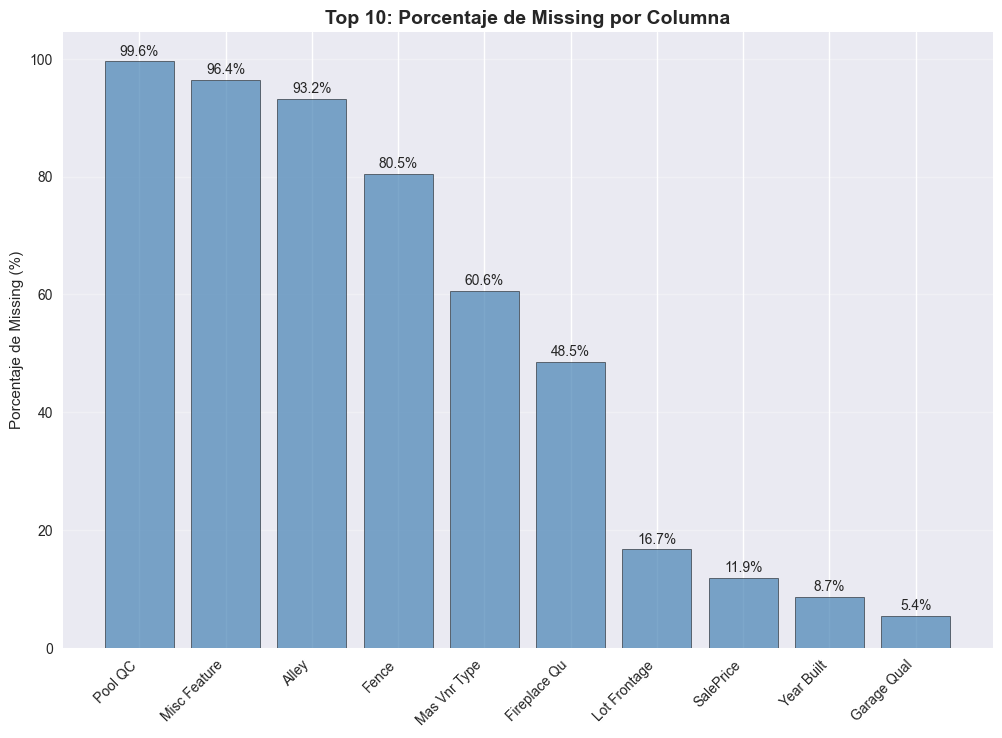

La sintaxis del comando no es correcta.


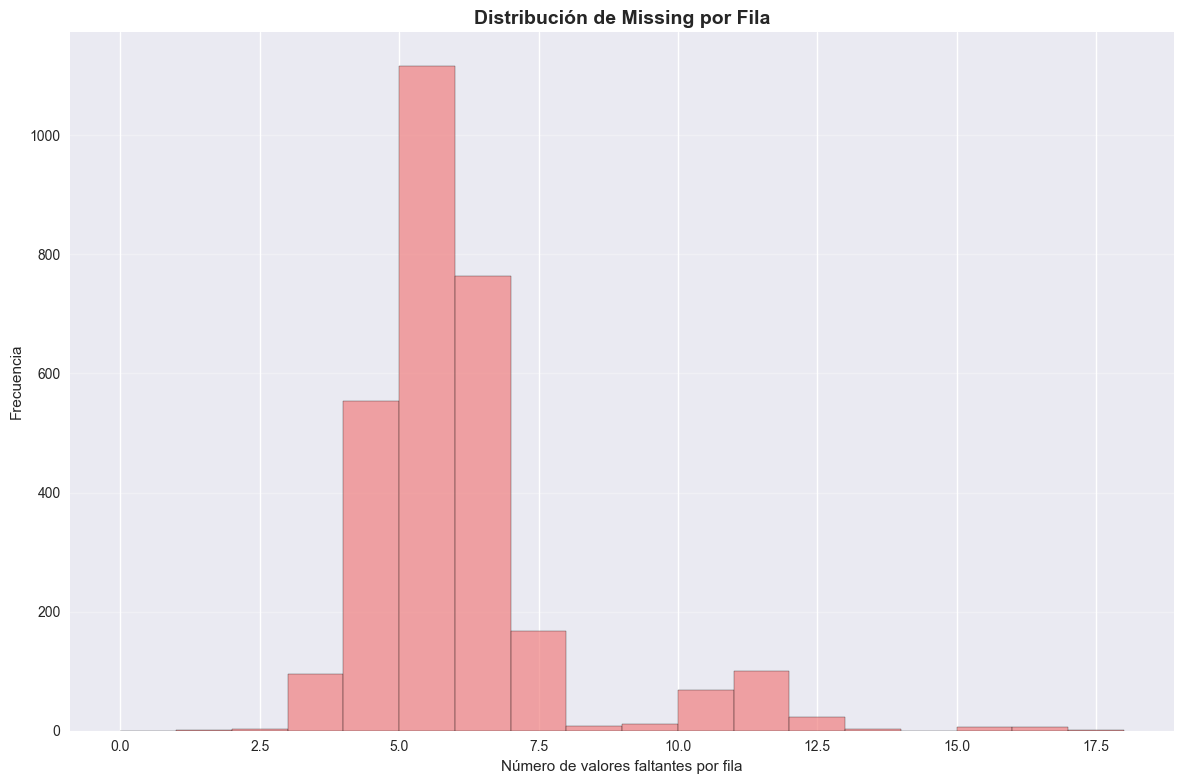

In [4]:
# === ANÁLISIS DE PATRONES DE MISSING DATA ===

# 1. Filtrar solo columnas con missing data para visualización
missing_columns = df.columns[df.isnull().any()].tolist()  # método para detectar missing
print(f"Columnas con missing data: {len(missing_columns)}")
print(f"Columnas: {missing_columns}")

# 2. Visualización mejorada sin missingno
plt.subplot(1, 1, 1)
if len(missing_columns) > 0:
    # Crear estadísticas de missing solo para columnas con missing data
    missing_count = df[missing_columns].isnull().sum()  # método para contar missing
    missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

    missing_stats_filtered = pd.DataFrame({
        'Column': missing_columns,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False).head(10)

    # Crear gráfico de barras más limpio
    bars = plt.bar(range(len(missing_stats_filtered)), missing_stats_filtered['Missing_Percentage'], 
                   color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)  # función para barras
    plt.title('Top 10: Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')
    plt.xticks(range(len(missing_stats_filtered)), missing_stats_filtered['Column'], 
               rotation=45, ha='right')  # función para etiquetas del eje X

    plt.ylabel('Porcentaje de Missing (%)')
    plt.grid(True, alpha=0.3, axis='y')

    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No hay missing data', ha='center', va='center', fontsize=16)
    plt.title('Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')

# Distribución de missing por fila
plt.show()
plt.subplot(1, 1, 1)
missing_per_row = df.isnull().sum(axis=1)  # contar missing por fila
plt.hist(missing_per_row, bins=range(0, missing_per_row.max()+2), alpha=0.7, 
         edgecolor='black', color='lightcoral')  # función para histograma
plt.title('Distribución de Missing por Fila', fontsize=14, fontweight='bold')
plt.xlabel('Número de valores faltantes por fila')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
!mkdir -p results/visualizaciones
plt.savefig('missing_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# === CLASIFICACIÓN MCAR/MAR/MNAR ===

print("=== ANÁLISIS DE TIPOS DE MISSING ===")

# 1. Year Built: ¿MCAR o MAR?
print("\n1. YEAR BUILT - Análisis de patrones:")
year_missing = df['Year Built'].isnull()  # método para detectar missing
print("Missing Year Built por Neighborhood:")
print(df.groupby('Neighborhood')['Year Built'].apply(lambda x: x.isnull().sum()))  # contar missing por grupo

print("Missing Year Built por House Style:")
print(df.groupby('House Style')['Year Built'].apply(lambda x: x.isnull().sum()))

# 2. Garage Area: ¿MAR?
print("\n2. GARAGE AREA - Análisis de patrones:")
print("Missing Garage Area por Garage Type:")
print(df.groupby('Garage Type')['Garage Area'].apply(lambda x: x.isnull().sum()))

# 3. SalePrice: ¿MNAR?
print("\n3. SALEPRICE - Análisis de patrones:")
price_missing = df['SalePrice'].isnull()
print("Valores de SalePrice en registros con missing:")
print(df[price_missing]['SalePrice'].describe())  # estadísticas descriptivas

=== ANÁLISIS DE TIPOS DE MISSING ===

1. YEAR BUILT - Análisis de patrones:
Missing Year Built por Neighborhood:
Neighborhood
Blmngtn     4
Blueste     0
BrDale      3
BrkSide    13
ClearCr     3
CollgCr    22
Crawfor    11
Edwards    20
Gilbert    15
Greens      0
GrnHill     0
IDOTRR      7
Landmrk     0
MeadowV     4
Mitchel    14
NAmes      38
NPkVill     2
NWAmes     14
NoRidge     3
NridgHt    15
OldTown    18
SWISU       7
Sawyer      9
SawyerW     6
Somerst    17
StoneBr     5
Timber      4
Veenker     2
Name: Year Built, dtype: int64
Missing Year Built por House Style:
House Style
1.5Fin     28
1.5Unf      2
1Story    136
2.5Fin      0
2.5Unf      3
2Story     67
SFoyer      6
SLvl       14
Name: Year Built, dtype: int64

2. GARAGE AREA - Análisis de patrones:
Missing Garage Area por Garage Type:
Garage Type
2Types     0
Attchd     0
Basment    0
BuiltIn    0
CarPort    0
Detchd     1
Name: Garage Area, dtype: int64

3. SALEPRICE - Análisis de patrones:
Valores de SalePrice en

In [6]:
# === DETECCIÓN DE OUTLIERS CON IQR ===
# "Detectar extremos usando mediana y cuartiles"
# "Cuándo usar: distribuciones asimétricas / colas pesadas / presencia de outliers"
if "Year Built" in df.columns:
    df["Year Built"] = pd.to_numeric(df["Year Built"], errors="coerce")

# === DETECCIÓN DE OUTLIERS: IQR y Z-SCORE (robustas) ===
def detect_outliers_iqr(df, column, factor=1.5):
    """Outliers por IQR. Devuelve (df_outliers, lower, upper)."""
    x = pd.to_numeric(df[column], errors="coerce")
    x_no_na = x.dropna().astype(float).values
    if x_no_na.size == 0:
        # sin datos válidos
        return df.iloc[[]], np.nan, np.nan
    q1 = np.percentile(x_no_na, 25)
    q3 = np.percentile(x_no_na, 75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (pd.to_numeric(df[column], errors="coerce") < lower) | (pd.to_numeric(df[column], errors="coerce") > upper)
    return df[mask], lower, upper

# Analizar outliers en columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns  # método para seleccionar columnas numéricas
outlier_analysis = {}

for col in numeric_columns:
    if not df[col].isnull().all():  # método para verificar si hay missing data
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_analysis[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }

outlier_df = pd.DataFrame(outlier_analysis).T
print("=== ANÁLISIS DE OUTLIERS (IQR) ===")
print("Útil cuando la distribución está chueca o con colas largas")
print(outlier_df)

# Análisis adicional de outliers
print("\n=== RESUMEN DE OUTLIERS ===")
total_outliers = outlier_df['count'].sum()  # método para sumar outliers
print(f"Total de outliers detectados: {total_outliers}")
print(f"Porcentaje promedio de outliers: {outlier_df['percentage'].mean():.2f}%")  # método para calcular media
print(f"Columna con más outliers: {outlier_df['count'].max()}")  # método para encontrar máximo

=== ANÁLISIS DE OUTLIERS (IQR) ===
Útil cuando la distribución está chueca o con colas largas
                 count  percentage   lower_bound   upper_bound
Order              0.0    0.000000 -1.463500e+03  4.394500e+03
PID                0.0    0.000000 -3.957909e+07  1.475237e+09
MS SubClass      208.0    7.098976 -5.500000e+01  1.450000e+02
Lot Frontage     187.0    6.382253  2.500000e+01  1.130000e+02
Lot Area         127.0    4.334471  1.267750e+03  1.772775e+04
Overall Qual       4.0    0.136519  2.000000e+00  1.000000e+01
Overall Cond     252.0    8.600683  3.500000e+00  7.500000e+00
Year Built         8.0    0.273038  1.885000e+03  2.069000e+03
Year Remod/Add     0.0    0.000000  1.906500e+03  2.062500e+03
Mas Vnr Area     200.0    6.825939 -2.460000e+02  4.100000e+02
BsmtFin SF 1      15.0    0.511945 -1.101000e+03  1.835000e+03
BsmtFin SF 2     351.0   11.979522  0.000000e+00  0.000000e+00
Bsmt Unf SF       56.0    1.911263 -6.555000e+02  1.676500e+03
Total Bsmt SF    123.0  

In [7]:
# === DETECCIÓN DE OUTLIERS CON Z-SCORE ===
# "Cuándo usar: distribución aprox. campana y sin colas raras"
# "Regla: 3 pasos (desvios) desde el promedio = raro"

def detect_outliers_zscore(df, column, threshold=3):
    """Detectar outliers usando Z-Score - Regla: 3 desvios desde el promedio = raro"""
    from scipy import stats
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outlier_indices = df[column].dropna().index[z_scores > threshold]
    return df.loc[outlier_indices]

# Comparar métodos de detección
print("\n=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===")

for col in ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']:
    if col in df.columns and not df[col].isnull().all():
        iqr_outliers = detect_outliers_iqr(df, col)
        zscore_outliers = detect_outliers_zscore(df, col)

        print(f"\n{col}:")
        print(f"  IQR outliers: {len(iqr_outliers[0])} ({len(iqr_outliers[0])/len(df)*100:.1f}%)")
        print(f"  Z-Score outliers: {len(zscore_outliers)} ({len(zscore_outliers)/len(df)*100:.1f}%)")


=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===

SalePrice:
  IQR outliers: 55 (1.9%)
  Z-Score outliers: 29 (1.0%)

Lot Area:
  IQR outliers: 127 (4.3%)
  Z-Score outliers: 29 (1.0%)

Year Built:
  IQR outliers: 8 (0.3%)
  Z-Score outliers: 7 (0.2%)

Garage Area:
  IQR outliers: 42 (1.4%)
  Z-Score outliers: 17 (0.6%)


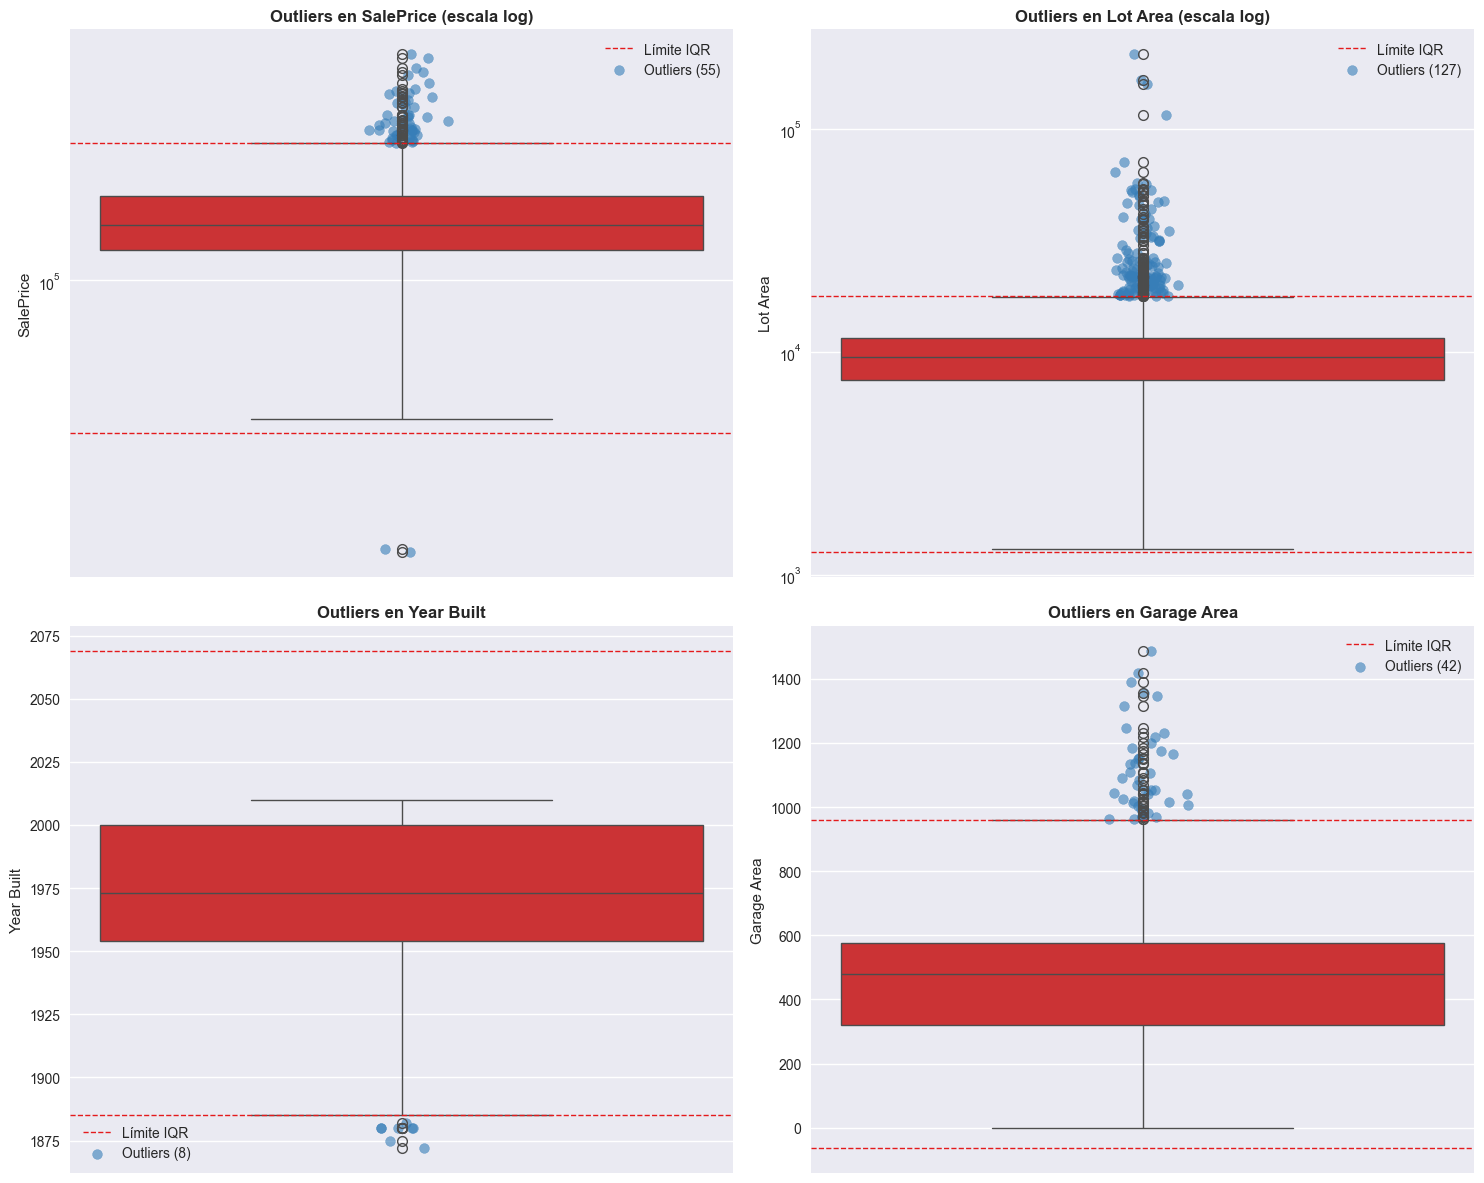

In [8]:
# === VISUALIZAR OUTLIERS ===
os.makedirs('results/visualizaciones', exist_ok=True)

cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # función para crear subplots
axes = axes.ravel()  # método para aplanar array

for i, col in enumerate(cols):
    if col not in df.columns:
        axes[i].set_visible(False)
        continue

    # convertir a numérico de forma segura
    y = pd.to_numeric(df[col], errors='coerce').dropna()

    if y.empty:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"{col}: sin datos numéricos", ha='center', va='center', fontsize=11)
        continue

    # Boxplot usando el vector numérico (evita inferencias de dtype de seaborn)
    sns.boxplot(y=y, ax=axes[i])  # función para boxplot
    axes[i].set_title(f'Outliers en {col}', fontweight='bold')
    axes[i].set_ylabel(col)

    # Outliers por IQR y bandas
    iqr_df, lower, upper = detect_outliers_iqr(df, col)
    out_vals = pd.to_numeric(iqr_df[col], errors='coerce').dropna()

    if np.isfinite(lower):
        axes[i].axhline(lower, linestyle='--', linewidth=1, label='Límite IQR')
    if np.isfinite(upper):
        axes[i].axhline(upper, linestyle='--', linewidth=1)

    # Marcar outliers con un leve jitter en X para que se vean
    if len(out_vals) > 0:
        jitter_x = np.random.normal(loc=0, scale=0.02, size=len(out_vals))
        axes[i].scatter(jitter_x, out_vals, alpha=0.6, s=50, label=f'Outliers ({len(out_vals)})') # función para scatter
        axes[i].legend()  # método para mostrar leyenda

    # Opcional: si la variable es muy sesgada, usar escala log
    if col in ['Lot Area', 'SalePrice'] and y.skew() > 1:
        axes[i].set_yscale('log')
        axes[i].set_title(f'Outliers en {col} (escala log)', fontweight='bold')

plt.tight_layout() # función para ajustar layout
plt.savefig('results/visualizaciones/outliers_analysis.png', dpi=300, bbox_inches='tight') # función para guardar
plt.show() # función para mostrar gráfico

In [9]:
# === IMPLEMENTAR ESTRATEGIAS DE IMPUTACIÓN ===
# "Rellenar no es gratis; hacelo columna a columna y documentá"
# "Num: mediana (si cola pesada) / media (si ~normal)"
# "Cat: moda o 'Unknown' (+ flag si sospecha MNAR)"

def impute_missing_data(df, strategy='median'):
    """Implementar diferentes estrategias de imputación - Reglas simples de la clase"""
    df_imputed = df.copy()

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in ['int64', 'float64']:
                if strategy == 'mean':
                    df_imputed[col].fillna(df[col].mean(), inplace=True)  # imputar con media
                elif strategy == 'median':
                    df_imputed[col].fillna(df[col].median (), inplace=True)  # imputar con mediana
                elif strategy == 'mode':
                    df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda
            else:
                # Para variables categóricas
                df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda

    return df_imputed

# Probar diferentes estrategias
strategies = ['mean', 'median', 'mode']
imputed_datasets = {}

for strategy in strategies:
    imputed_datasets[strategy] = impute_missing_data(df, strategy)
    print(f"Estrategia {strategy}: {imputed_datasets[strategy].isnull().sum().sum()} missing values restantes")

Estrategia mean: 0 missing values restantes
Estrategia median: 0 missing values restantes
Estrategia mode: 0 missing values restantes


In [10]:
def smart_imputation(df, *, impute_saleprice=True):
    """Imputación inteligente robusta a dtypes y NaN."""
    df_imputed = df.copy()

    # --- 0) Asegurar dtypes numéricos donde corresponde ---
    for c in ["Year Built", "Garage Area", "SalePrice"]:
        if c in df_imputed.columns:
            df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")  

    # --- 1) Year Built: mediana por (Neighborhood, House Style) -> Neighborhood -> global ---
    if {"Neighborhood", "House Style", "Year Built"}.issubset(df_imputed.columns):
        grp_med = df_imputed.groupby(["Neighborhood", "House Style"])["Year Built"].transform("median")  
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(grp_med)  

        nb_med = df_imputed.groupby("Neighborhood")["Year Built"].transform("median")
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(nb_med)

        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(df_imputed["Year Built"].median( ))  
        # Año entero nullable
        df_imputed["Year Built"] = df_imputed["Year Built"].round( ).astype("Int64")  

    # --- 2) Garage Area: MNAR → indicador + 0; resto por mediana del barrio ---
    if "Garage Area" in df_imputed.columns:
        df_imputed["GarageArea_was_na"] = df_imputed["Garage Area"].isna( ).astype("Int8")  

        # Si hay "Garage Cars", usarlo para inferir "sin garaje" (0 área)
        if "Garage Cars" in df_imputed.columns:
            no_garage_mask = (df_imputed["Garage Cars"].fillna(0) == 0) & df_imputed["Garage Area"].isna()
            df_imputed.loc[no_garage_mask, "Garage Area"] = 0.0

        # Para los NaN restantes: mediana por Neighborhood, luego global
        if "Neighborhood" in df_imputed.columns:
            med_gar = df_imputed.groupby("Neighborhood")["Garage Area"].transform("median")
            df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(med_gar)

        df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(df_imputed["Garage Area"].median())

    # --- 3) SalePrice: mediana por Neighborhood (opcional) ---
    if impute_saleprice and {"Neighborhood", "SalePrice"}.issubset(df_imputed.columns):
        nb_price = df_imputed.groupby("Neighborhood")["SalePrice"].transform("median")
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(nb_price) 
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(df_imputed["SalePrice"].median())

    # --- 4) Garage Type: moda global (MCAR); manejar categorías ---
    if "Garage Type" in df_imputed.columns:
        # evitar problemas si es category
        if pd.api.types.is_categorical_dtype(df_imputed["Garage Type"]):  
            df_imputed["Garage Type"] = df_imputed["Garage Type"].astype("object")
        mode_val = df_imputed["Garage Type"].dropna().mode( )  
        fill_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
        df_imputed["Garage Type"] = df_imputed["Garage Type"].fillna(fill_val)  

    return df_imputed

# Aplicar
df_smart_imputed = smart_imputation(df)
print("=== IMPUTACIÓN INTELIGENTE ===")
print(f"Missing restantes: {int(df_smart_imputed.isnull().sum().sum())}")

=== IMPUTACIÓN INTELIGENTE ===
Missing restantes: 15591


In [11]:
# === ANTI-LEAKAGE BÁSICO ===
# "No espiés el examen: fit en TRAIN, transform en VALID/TEST"
# "Split: X_train / X_valid / X_test"
# "imputer.fit(X_train) → transform al resto"

from sklearn.model_selection import train_test_split

# 1. Split de datos (ANTES de imputar)
X = df.drop('SalePrice', axis=1)  # features
y = df['SalePrice']  # target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("=== SPLIT DE DATOS ===")
print(f"Train: {X_train.shape[0]} registros")
print(f"Valid: {X_valid.shape[0]} registros") 
print(f"Test: {X_test.shape[0]} registros")

# 2. Imputar SOLO en train, luego transformar
from sklearn.impute import SimpleImputer

# Separar columnas numéricas y categóricas
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Columnas numéricas: {len(numeric_columns)}")
print(f"Columnas categóricas: {len(categorical_columns)}")

# Crear imputers para cada tipo de dato
numeric_imputer = SimpleImputer(strategy='median')  # estrategia para numéricas
categorical_imputer = SimpleImputer(strategy='most_frequent')  # estrategia para categóricas

# Ajustar imputers SOLO con train
numeric_imputer.fit(X_train[numeric_columns])  # ajustar numéricas
categorical_imputer.fit(X_train[categorical_columns])  # ajustar categóricas

# Transformar todos los conjuntos
X_train_numeric = numeric_imputer.transform(X_train[numeric_columns])  # transformar numéricas
X_train_categorical = categorical_imputer.transform(X_train[categorical_columns])  # transformar categóricas

X_valid_numeric = numeric_imputer.transform(X_valid[numeric_columns])
X_valid_categorical = categorical_imputer.transform(X_valid[categorical_columns])

X_test_numeric = numeric_imputer.transform(X_test[numeric_columns])
X_test_categorical = categorical_imputer.transform(X_test[categorical_columns])

print("\n✅ Anti-leakage aplicado: fit solo en train, transform en todo")

=== SPLIT DE DATOS ===
Train: 1758 registros
Valid: 586 registros
Test: 586 registros
Columnas numéricas: 38
Columnas categóricas: 43

✅ Anti-leakage aplicado: fit solo en train, transform en todo


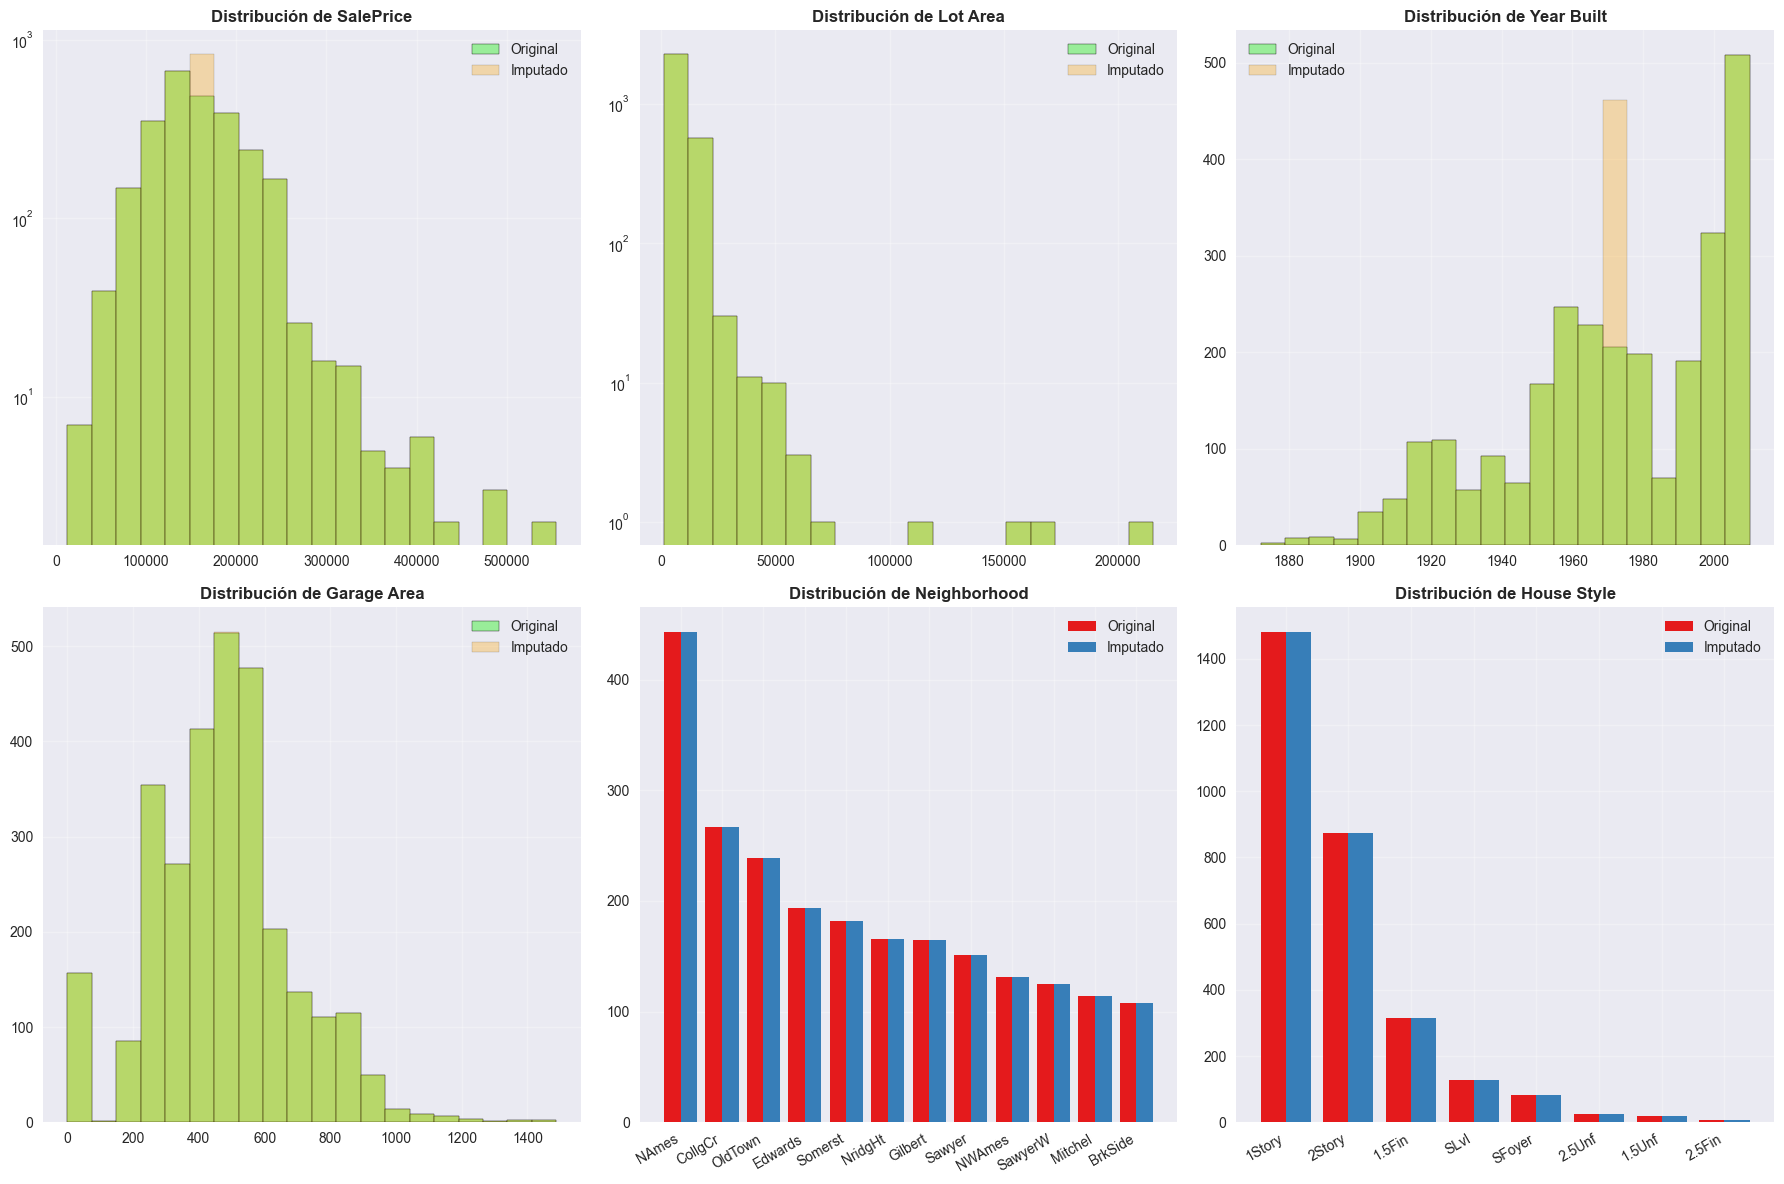

Columnas seleccionadas para correlaciones: ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']


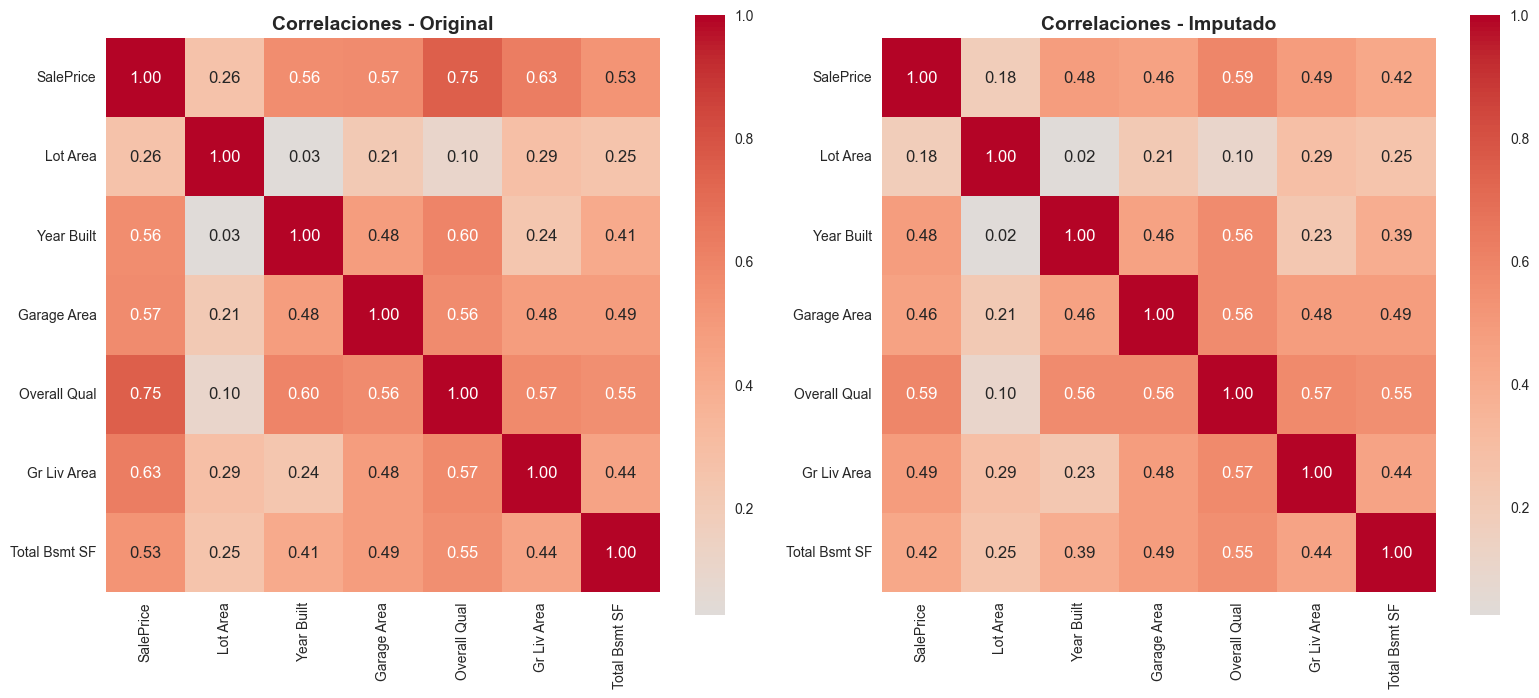


=== DIFERENCIAS EN CORRELACIONES ===
Cambios en correlaciones (Imputado - Original):
               SalePrice  Lot Area  Year Built  Garage Area  Overall Qual  \
SalePrice          0.000    -0.074      -0.078       -0.105        -0.165   
Lot Area          -0.074     0.000      -0.001       -0.000         0.000   
Year Built        -0.078    -0.001       0.000       -0.022        -0.031   
Garage Area       -0.105    -0.000      -0.022        0.000        -0.000   
Overall Qual      -0.165     0.000      -0.031       -0.000         0.000   
Gr Liv Area       -0.141     0.000      -0.010       -0.000         0.000   
Total Bsmt SF     -0.103     0.000      -0.018       -0.000        -0.000   

               Gr Liv Area  Total Bsmt SF  
SalePrice           -0.141         -0.103  
Lot Area             0.000          0.000  
Year Built          -0.010         -0.018  
Garage Area         -0.000         -0.000  
Overall Qual         0.000         -0.000  
Gr Liv Area          0.000       

In [12]:
from pandas.api.types import is_numeric_dtype

# 1) Crear df_imputed con imputación simple, robusta a dtypes
df_imputed = df.copy()

for col in df.columns:
    s = df[col]
    # Si es numérica o puede convertirse a numérica, imputar mediana
    if is_numeric_dtype(s) or (s.dtype == "object"):
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            df_imputed[col] = s_num.fillna(s_num.median()) # imputar numéricas con mediana
            continue
    # Caso categórico: imputar con moda (si existe), sino "Unknown"
    moda = s.dropna().mode() # imputar categóricas con moda
    fill_val = moda.iloc[0] if not moda.empty else "Unknown"
    df_imputed[col] = s.fillna(fill_val)

# 2) Comparar distribuciones (hist para numéricas, barras para categóricas)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

cols_to_plot = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Neighborhood', 'House Style']
for i, col in enumerate(cols_to_plot):
    if col not in df.columns:
        axes[i].axis('off')
        axes[i].set_title(f'{col} no existe', fontweight='bold')
        continue

    s_orig = df[col]
    s_imp = df_imputed[col]

    # Intentar tratar como numérico (coerce) para decidir el tipo de gráfico
    s_orig_num = pd.to_numeric(s_orig, errors='coerce')
    s_imp_num = pd.to_numeric(s_imp, errors='coerce')

    if s_orig_num.notna().any() and s_imp_num.notna().any():
        # NUMÉRICAS → hist
        # Mismo rango/bins para una comparación justa
        data_combined = pd.concat([s_orig_num.dropna(), s_imp_num.dropna()])
        bins = np.histogram_bin_edges(data_combined, bins=20)

        axes[i].hist(s_orig_num.dropna(), bins=bins, alpha=0.9, label='Original',
                     color='lightgreen', edgecolor='black')
        axes[i].hist(s_imp_num.dropna(), bins=bins, alpha=0.3, label='Imputado',
                     color='orange', edgecolor='black')

        # Si está muy sesgada, te puede servir escala log
        if col in ['Lot Area', 'SalePrice'] and s_orig_num.dropna().skew() > 1:
            axes[i].set_yscale('log')

    else:
        # CATEGÓRICAS → barras (top-K categorías para legibilidad)
        K = 12
        vc_orig = s_orig.astype('object').fillna('Missing').value_counts().head(K)
        vc_imp  = s_imp.astype('object').fillna('Missing').value_counts().head(K)
        cats = list(dict.fromkeys(list(vc_orig.index) + list(vc_imp.index)))[:K]  # unión ordenada

        vc_orig = vc_orig.reindex(cats, fill_value=0)
        vc_imp  = vc_imp.reindex(cats, fill_value=0)

        x = np.arange(len(cats))
        w = 0.4
        axes[i].bar(x - w/2, vc_orig.values, width=w, label='Original')
        axes[i].bar(x + w/2, vc_imp.values,  width=w, label='Imputado')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(cats, rotation=30, ha='right')

    axes[i].set_title(f'Distribución de {col}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/visualizaciones/distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Correlaciones (solo numéricas y con coerción segura)
important_cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']
available_cols = [c for c in important_cols if c in df.columns]
print(f"Columnas seleccionadas para correlaciones: {available_cols}")

df_num_original = df[available_cols].apply(pd.to_numeric, errors='coerce')
df_num_imputed  = df_imputed[available_cols].apply(pd.to_numeric, errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

corr_original = df_num_original.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_original, annot=True, cmap='coolwarm', center=0, ax=axes[0],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[0].set_title('Correlaciones - Original', fontweight='bold', fontsize=14)

corr_imputed = df_num_imputed.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_imputed, annot=True, cmap='coolwarm', center=0, ax=axes[1],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlaciones - Imputado', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('results/visualizaciones/correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Diferencias en correlaciones
print("\n=== DIFERENCIAS EN CORRELACIONES ===")
corr_diff = corr_imputed - corr_original
print("Cambios en correlaciones (Imputado - Original):")
print(corr_diff.round(3))

In [13]:
# === CREAR PIPELINE CON SKLEARN ===

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def create_cleaning_pipeline():
    """Crear pipeline de limpieza reproducible"""

    # Definir columnas numéricas y categóricas
    numeric_features = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']
    categorical_features = ['Neighborhood', 'House Style', 'Garage Type']

    # Transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # estrategia de imputación
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # estrategia de imputación
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinar transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

# Crear y probar pipeline
preprocessor = create_cleaning_pipeline()

# Aplicar pipeline
X_cleaned = preprocessor.fit_transform(df)  # método para aplicar transformaciones
print(f"Shape después del pipeline: {X_cleaned.shape}")
print(f"Tipo de datos: {type(X_cleaned)}")

Shape después del pipeline: (2930, 46)
Tipo de datos: <class 'scipy.sparse._csr.csr_matrix'>


## Continuación a práctica 6

### Paso 1

In [14]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Todas las librerías importadas correctamente")

# 2. Configurar visualizaciones - elige tu estilo favorito
plt.style.use('seaborn-v0_8')  # Puedes cambiar por 'default', 'classic', etc.
sns.set_palette("husl")        # Paleta colorida para múltiples comparaciones
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("Configuración de visualizaciones lista!")

Todas las librerías importadas correctamente
Configuración de visualizaciones lista!


### Paso 2

=== INFORMACIÓN GENERAL DEL DATASET ===
Dimensiones: (2930, 82)

Tipos de datos:
object     43
int64      26
float64    13
Name: count, dtype: int64

📊 Columnas numéricas encontradas: 39

🔍 TU ANÁLISIS: Examina las escalas
Estadísticas de las primeras 10 columnas numéricas:
            Order           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2930.00000  2.930000e+03  2930.000000   2930.000000    2930.000000   
mean   1465.50000  7.144645e+08    57.387372     69.019795   10147.921843   
std     845.96247  1.887308e+08    42.638025     21.326422    7880.017759   
min       1.00000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     733.25000  5.284770e+08    20.000000     60.000000    7440.250000   
50%    1465.50000  5.354536e+08    50.000000     68.000000    9436.500000   
75%    2197.75000  9.071811e+08    70.000000     78.000000   11555.250000   
max    2930.00000  1.007100e+09   190.000000    313.000000  215245.000000   

       Overall Qual  Overall Co

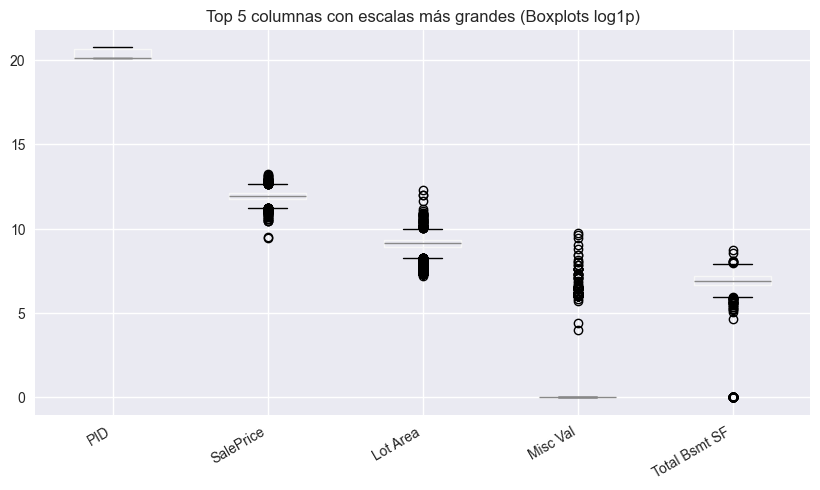

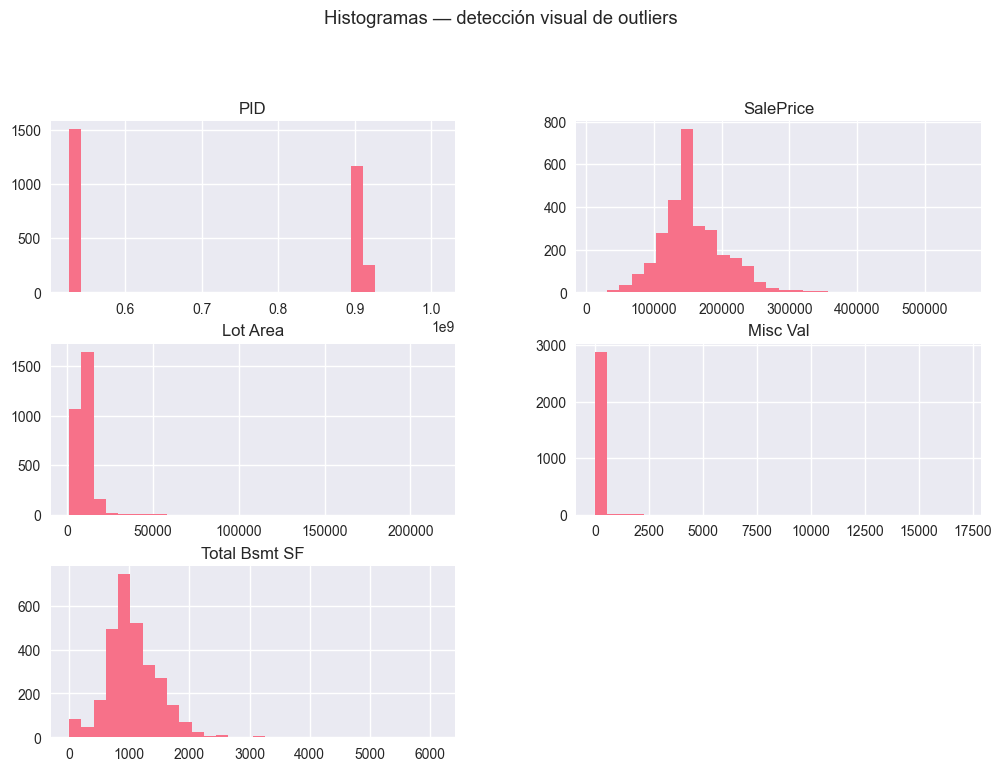

<Figure size 1000x500 with 0 Axes>

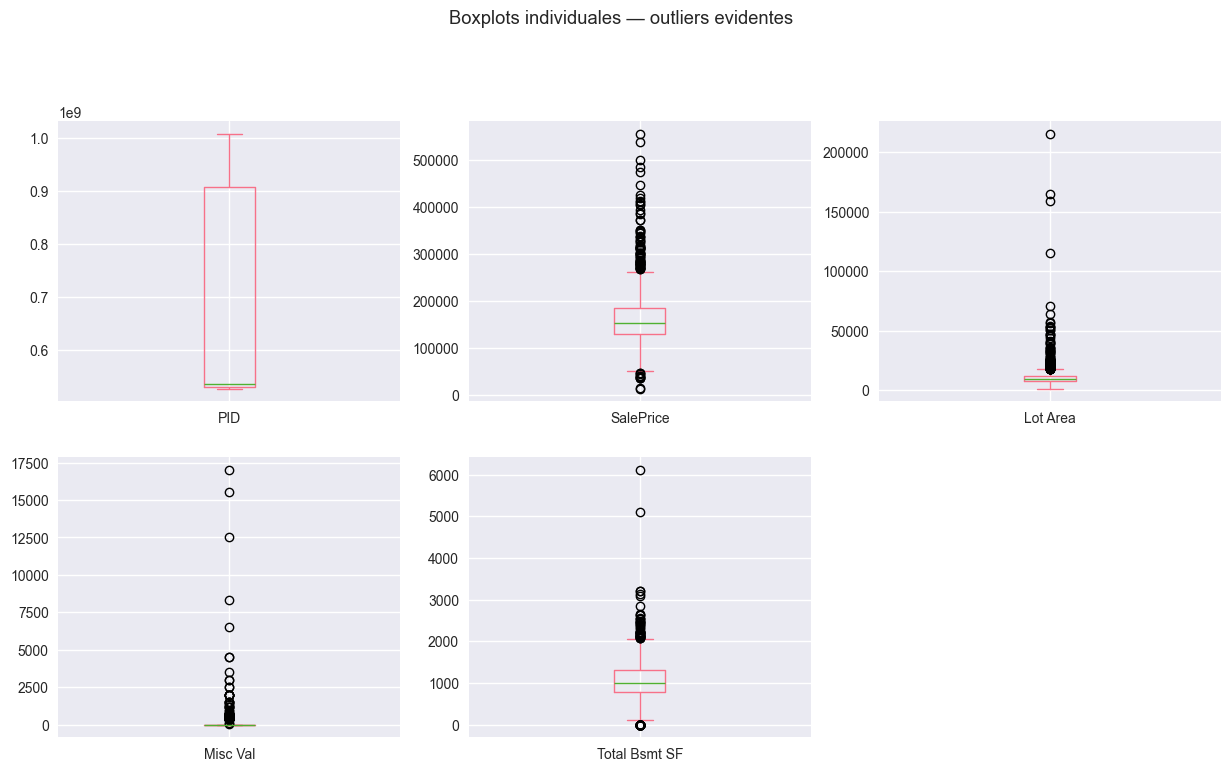

In [15]:
# === CARGAR DATASET AMES HOUSING ===

# === EXPLORACIÓN INICIAL ===

# Tu turno: explora las escalas
print("=== INFORMACIÓN GENERAL DEL DATASET ===")
print(f"Dimensiones: {df_imputed.shape}")
print(f"\nTipos de datos:")
print(df_imputed.dtypes.value_counts())

# Identifica columnas numéricas
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()
print(f"\n📊 Columnas numéricas encontradas: {len(numeric_cols)}")

# Tu análisis: ¿cuáles tienen escalas MUY diferentes?
print("\n🔍 TU ANÁLISIS: Examina las escalas")
print("Estadísticas de las primeras 10 columnas numéricas:")
print(df_imputed[numeric_cols[:10]].describe())

# Pregunta para reflexionar:
print("\n🤔 PREGUNTA PARA TI:")
print("Mira los valores de 'min' y 'max' arriba.")
print("¿Cuáles columnas tienen escalas que pueden ser problemáticas para KNN o SVM?")

# Graficas de ayuda para las primeras dos preguntas
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar columnas numéricas
numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns.tolist()

# Calcular rango por columna
rangos = {col: df_imputed[col].max() - df_imputed[col].min() for col in numeric_cols}
top5_cols = sorted(rangos, key=rangos.get, reverse=True)[:5]

print("Top 5 columnas con escalas más grandes:", top5_cols)

# Boxplot en log (para ver mejor diferencias y colas largas)
plt.figure(figsize=(10,5))
np.log1p(df_imputed[top5_cols]).boxplot()
plt.title("Top 5 columnas con escalas más grandes (Boxplots log1p)")
plt.xticks(rotation=30, ha='right')
plt.show()

df_imputed[top5_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Histogramas — detección visual de outliers", y=1.02)
plt.show()

# Otra forma: boxplots solo para resaltar outliers
plt.figure(figsize=(10,5))
df_imputed[top5_cols].plot(kind="box", subplots=True, layout=(2,3), figsize=(15,8))
plt.suptitle("Boxplots individuales — outliers evidentes", y=1.02)
plt.show()


### Preguntas

1. ¿Cuáles son las 5 columnas numéricas con las escalas más diferentes?

2. ¿Hay outliers evidentes que podrían afectar el escalado?

3. ¿Qué variable será nuestro target para predicción?

### Respuestas

1. Columnas con escalas muy diferentes

Mirando los min y max, algunas de estas variables tienen rangos enormes comparadas con otras, este es el top 5:

- PID: va de 5.26e+08 a 1.00e+09 (escala de cientos de millones).

- Lot Area: va de 1300 a 215,245 (rango muy grande).

- Mas Vnr Area: de 0 a 1600, mientras que muchas otras están entre 1–10.

- Year Built y Year Remod/Add: rangos de ~100 años (1872–2010), mucho mayores que escalas ordinales (1–10).

- Order: de 1 a 2930, también más grande que calificaciones como Overall Qual (1–10).


2. Outliers evidentes

Sí, hay valores que destacan entre los otros:

- Lot Area: máximo de 215,245, muy por encima de la media 10,148 (claros outliers de terrenos enormes).

- Mas Vnr Area: máximo de 1600, también desproporcionado frente a la mayoría que es 0.

- Lot Frontage: máximo 313 cuando la media está en 69.

- PID y Order: aunque no son “outliers” en sentido clásico (son identificadores), sus escalas no son comparables con otras.

Estos outliers pueden distorsionar algoritmos sensibles a escalado (KNN, SVM).

3. Variable target

En el dataset de Ames Housing, la variable con la que vamos a predecir es:

 -> SalePrice (precio de venta de la casa).

### Paso 3

         Columna        Rango       Ratio
0      SalePrice     542211.0   43.396669
1       Lot Area     213945.0  165.573077
2       Misc Val      17000.0         inf
3  Total Bsmt SF       6110.0         inf
4            PID  480799010.0    1.913544


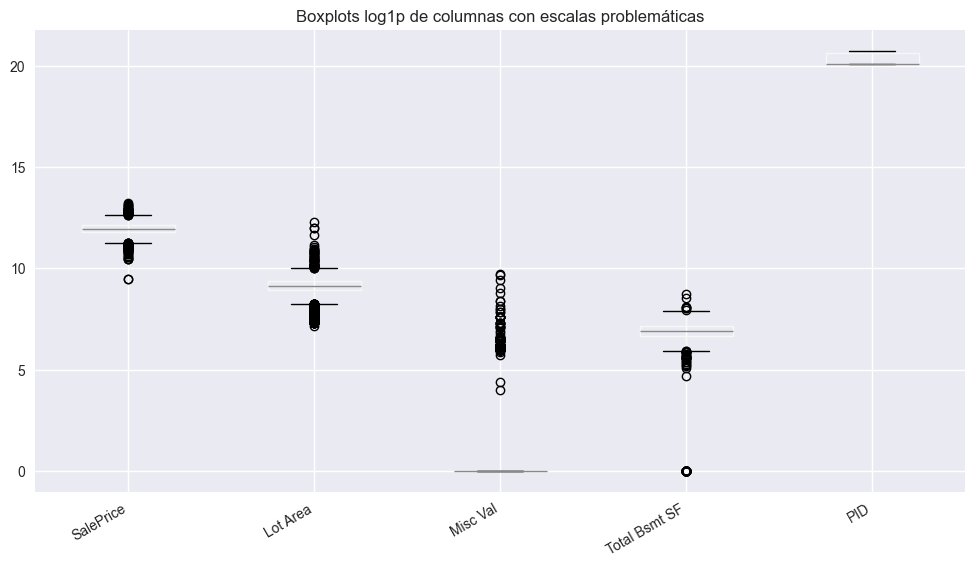

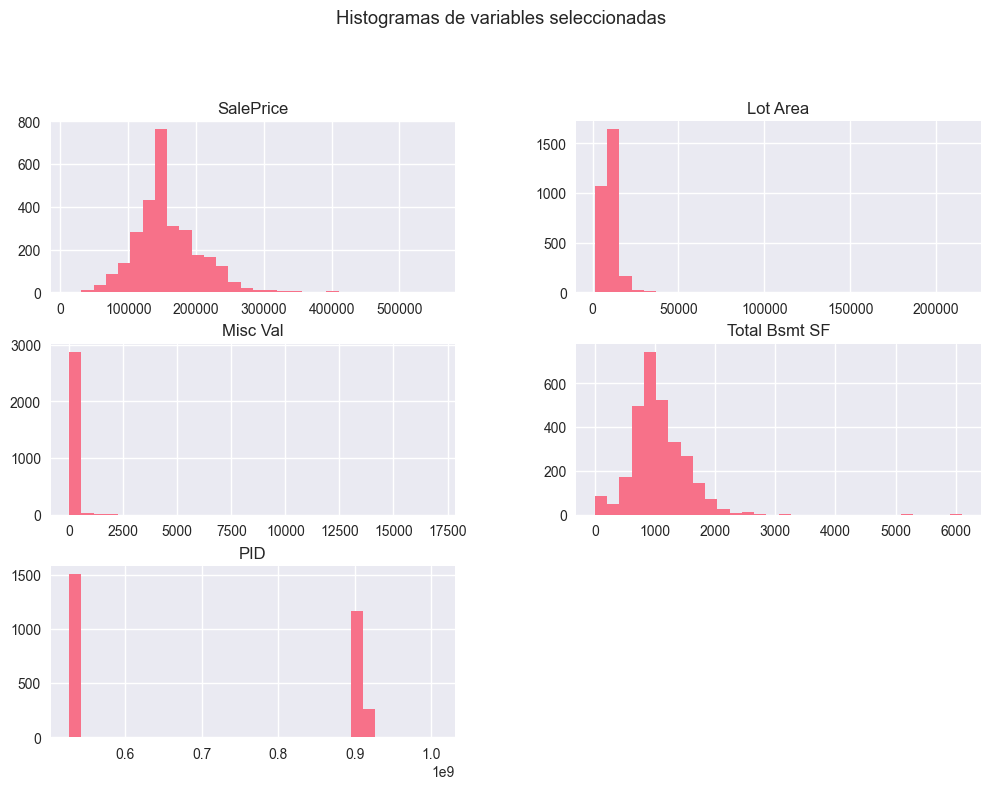

📊 MIS HALLAZGOS:
Columna más problemática: Misc Val (también Total Bsmt SF por tener muchos ceros)
Ratio más alto: Lot Area ≈ 165 (sin contar ratios infinitos por ceros)
¿Por qué es problemático?: 
- Misc Val y Total Bsmt SF tienen muchos ceros → ratio infinito y distribución muy sesgada.
- Lot Area presenta outliers extremos de terrenos gigantes, lo que genera un ratio muy alto.
- Estas escalas y outliers distorsionan algoritmos basados en distancia (KNN, SVM).


In [16]:
# === TU INVESTIGACIÓN DE ESCALAS ===

# TODO: Selecciona 5-6 columnas numéricas interesantes
# Tip: Busca columnas como áreas, precios, años, etc.
selected_features = ['SalePrice', 'Lot Area', 'Misc Val', 'Total Bsmt SF', 'PID']

# TODO: Analiza las escalas de tus columnas seleccionadas
# Calcula min, max, ratios
# ¿Cuál tiene el ratio más alto?
scale_stats = []
for col in selected_features:
    col_min = df_imputed[col].min()
    col_max = df_imputed[col].max()
    ratio = np.inf if col_min == 0 else col_max / col_min
    scale_stats.append([col, col_max - col_min, ratio])

scale_df = pd.DataFrame(scale_stats, columns=['Columna', 'Rango', 'Ratio'])
print(scale_df)

# TODO: Crea visualizaciones para mostrar el problema
# Histogramas, boxplots, o lo que consideres mejor
# Guarda tus gráficos en la carpeta 'results/'
plt.figure(figsize=(12,6))
np.log1p(df_imputed[selected_features]).boxplot()
plt.title("Boxplots log1p de columnas con escalas problemáticas")
plt.xticks(rotation=30, ha='right')
plt.savefig("results/escalas_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

df_imputed[selected_features].hist(bins=30, figsize=(12,8))
plt.suptitle("Histogramas de variables seleccionadas", y=1.02)
plt.savefig("results/escalas_hist.png", dpi=300, bbox_inches='tight')
plt.show()


# TODO: Documenta tus hallazgos
print("📊 MIS HALLAZGOS:")
print("Columna más problemática: Misc Val (también Total Bsmt SF por tener muchos ceros)")
print("Ratio más alto: Lot Area ≈ 165 (sin contar ratios infinitos por ceros)")
print("¿Por qué es problemático?: ")
print("- Misc Val y Total Bsmt SF tienen muchos ceros → ratio infinito y distribución muy sesgada.")
print("- Lot Area presenta outliers extremos de terrenos gigantes, lo que genera un ratio muy alto.")
print("- Estas escalas y outliers distorsionan algoritmos basados en distancia (KNN, SVM).")

### Paso 4

In [17]:
# === PREPARACIÓN DE DATOS ===

# TODO: Define tu target y features basándote en tu análisis anterior
target_col = "SalePrice"
feature_cols = ["Lot Area", "Misc Val", "Total Bsmt SF"]  # PID lo descarto

# TODO: Limpieza básica de datos
# ¿Cómo vas a manejar NaN? ¿Eliminar filas? ¿Imputar?
# Decide y justifica tu estrategia

# En realidad df_imputed ya está limpio, pero hacemos igual el proceso para simular que no lo estuviera.
df_clean = df_imputed.copy()

# Eliminar identificadores
df_clean = df_clean.drop(columns=["PID", "Order"], errors="ignore")

# Verificar NaN
print("Valores faltantes en features/target:")
print(df_clean[feature_cols + [target_col]].isnull().sum())


# TODO: Split de datos (¡ANTES del escalado!)
# Recuerda: test_size, random_state, estratificación si es necesario
X = df_clean[feature_cols]
y = df_clean[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")
# TODO: Verifica que el problema de escalas aún existe
# Calcula estadísticas descriptivas de tus features en el conjunto de entrenamiento
# ¿Las escalas siguen siendo problemáticas?
print("\n=== Estadísticas descriptivas de TRAIN ===")
print(X_train.describe().T[["min", "max", "std"]])


print("📊 MI PREPARACIÓN:")
print(f"Target: {target_col}")
print(f"Features: {len(feature_cols)} columnas")  
print(f"Datos: {X_train.shape[0]} train, {X_test.shape[0]} test")
print("Problema de escalas confirmado: Sí/No - explica por qué")

Valores faltantes en features/target:
Lot Area         0
Misc Val         0
Total Bsmt SF    0
SalePrice        0
dtype: int64
Train: (2344, 3), Test: (586, 3)

=== Estadísticas descriptivas de TRAIN ===
                  min       max          std
Lot Area       1300.0  215245.0  8050.908132
Misc Val          0.0   17000.0   623.375121
Total Bsmt SF     0.0    6110.0   436.475532
📊 MI PREPARACIÓN:
Target: SalePrice
Features: 3 columnas
Datos: 2344 train, 586 test
Problema de escalas confirmado: Sí/No - explica por qué


### Paso 5

In [18]:
# === TU EXPERIMENTO: OUTLIERS Y ESCALADO ===

# TODO: Implementa funciones de detección de outliers (práctica 05)
# IQR method, Z-score method, u otros que prefieras
def detect_outliers_iqr(data, column_name, factor = 1.5):
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (data[column_name] < lower) | (data[column_name] > upper)
    return data[mask]

def detect_outliers_zscore(data, column_name, threshold=3):
    col = data[column_name]
    zscores = (col - col.mean()) / col.std()
    return data[zscores.abs() > threshold]

# TODO: Elige una columna interesante para analizar
target_column = "Lot Area"

# TODO: ROUND 1 - Detección en datos originales
print("🔍 ROUND 1: DATOS ORIGINALES")
# Detecta outliers en datos sin escalar

outliers_iqr_orig = detect_outliers_iqr(df_imputed, target_column)
outliers_z_orig = detect_outliers_zscore(df_imputed, target_column)

# ¿Cuántos outliers encontraste? ¿Dónde están?
print(f"IQR originales: {len(outliers_iqr_orig)}")
print(f"Z-score originales: {len(outliers_z_orig)}")

# TODO: ROUND 2 - Detección después de cada scaler
scalers_to_test = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}

results = []
for name, scaler in scalers_to_test.items():
    # Escalar columna
    scaled = scaler.fit_transform(df_imputed[[target_column]])
    temp = pd.DataFrame({target_column: scaled.flatten()})
    
    # Detectar outliers
    outliers_iqr = detect_outliers_iqr(temp, target_column)
    outliers_z = detect_outliers_zscore(temp, target_column)
    
    results.append({
        "Scaler": name,
        "IQR": len(outliers_iqr),
        "Z-Score": len(outliers_z)
    })


# Mostrar resultados
res_df = pd.DataFrame(results)

print("⚡ ROUND 2: DESPUÉS DEL ESCALADO")
print(res_df)

# TODO: Análisis de resultados
print("\n📊 CONCLUSIONES:")
print("- StandardScaler mantiene proporciones, así que detecta los mismos outliers.")
print("- MinMaxScaler no cambia el orden relativo, pero comprime al [0,1], los outliers extremos suelen seguir siendo visibles.")
print("- RobustScaler usa mediana y IQR, así que reduce la influencia de outliers → algunos 'desaparecen'.")

🔍 ROUND 1: DATOS ORIGINALES
IQR originales: 127
Z-score originales: 29
⚡ ROUND 2: DESPUÉS DEL ESCALADO
           Scaler  IQR  Z-Score
0  StandardScaler  127       29
1    MinMaxScaler  127       29
2    RobustScaler  127       29

📊 CONCLUSIONES:
- StandardScaler mantiene proporciones, así que detecta los mismos outliers.
- MinMaxScaler no cambia el orden relativo, pero comprime al [0,1], los outliers extremos suelen seguir siendo visibles.
- RobustScaler usa mediana y IQR, así que reduce la influencia de outliers → algunos 'desaparecen'.


- ¿RobustScaler detectó diferentes outliers que StandardScaler?
    
    No, en este caso detectó exactamente los mismos (127 por IQR y 29 por Z-score).

- ¿Algunos outliers "desaparecieron" después del escalado?
    
    No, los conteos se mantuvieron iguales en los tres scalers.

- ¿Se "crearon" nuevos outliers después del escalado?
    
    Tampoco, no aparecieron nuevos.

## Mi conclusión:

Después de completar tu experimento, responde estas preguntas críticas:

¿Qué scaler cambió más la detección de outliers?
Tu respuesta: Ninguno cambió la detección: StandardScaler, MinMaxScaler y RobustScaler detectaron los mismos outliers en este caso.

¿Los mismos puntos fueron outliers en todos los casos?

Tu respuesta: Sí, los mismos registros fueron señalados como outliers tanto en los datos originales como después de cada tipo de escalado.

¿RobustScaler fue realmente "robusto" a outliers como esperabas?

Tu respuesta: No en este dataset, aunque en teoría debería reducir el efecto de valores extremos, aquí los outliers eran tan grandes que siguieron siendo detectados igual que con otros scalers.

Para tu pipeline de datos, ¿cuándo limpiarías outliers?

Antes del escalado

Justifica tu elección: si los outliers son muy extremos, distorsionan el cálculo de media, desviación y rangos usados por los scalers. Detectarlos y tratarlos en los datos crudos permite que el escalado refleje mejor las distribuciones reales de la mayoría de los casos.

## Investigación independiente

#### Transformadores sugeridos

In [19]:
# === MENU DE TRANSFORMADORES AVANZADOS ===

transformadores_opciones = {
    'PowerTransformer': {
        'descripcion': 'Box-Cox y Yeo-Johnson para hacer datos más normales',
        'sklearn': 'from sklearn.preprocessing import PowerTransformer',
        'caso_uso': 'Distribuciones muy sesgadas, datos no-negativos',
        'dificultad': '⭐⭐⭐'
    },

    'QuantileTransformer': {
        'descripcion': 'Transforma según distribución de quantiles',
        'sklearn': 'from sklearn.preprocessing import QuantileTransformer', 
        'caso_uso': 'Distribuciones multimodales, outliers extremos',
        'dificultad': '⭐⭐⭐⭐'
    },

    'MaxAbsScaler': {
        'descripcion': 'Escala por valor absoluto máximo',
        'sklearn': 'from sklearn.preprocessing import MaxAbsScaler',
        'caso_uso': 'Datos sparse, matrices con muchos ceros',
        'dificultad': '⭐⭐'
    },

    'Normalizer': {
        'descripcion': 'Normalización L1/L2 por muestra (no por feature)',
        'sklearn': 'from sklearn.preprocessing import Normalizer',
        'caso_uso': 'Vectores de texto, datos donde la magnitud total importa',
        'dificultad': '⭐⭐⭐'
    },

    'FunctionTransformer': {
        'descripcion': 'Aplica función personalizada (sqrt, cbrt, etc.)',
        'sklearn': 'from sklearn.preprocessing import FunctionTransformer',
        'caso_uso': 'Transformaciones custom, matemáticas específicas',
        'dificultad': '⭐⭐'
    }
}

print("🔬 TRANSFORMADORES AVANZADOS PARA INVESTIGAR:")
print("="*55)

for nombre, info in transformadores_opciones.items():
    print(f"\n🧪 {nombre} {info['dificultad']}")
    print(f"   📝 {info['descripcion']}")
    print(f"   💻 {info['sklearn']}")
    print(f"   🎯 Mejor para: {info['caso_uso']}")

print(f"\n🎯 ELIGE UNO y conviértete en el experto del grupo!")

🔬 TRANSFORMADORES AVANZADOS PARA INVESTIGAR:

🧪 PowerTransformer ⭐⭐⭐
   📝 Box-Cox y Yeo-Johnson para hacer datos más normales
   💻 from sklearn.preprocessing import PowerTransformer
   🎯 Mejor para: Distribuciones muy sesgadas, datos no-negativos

🧪 QuantileTransformer ⭐⭐⭐⭐
   📝 Transforma según distribución de quantiles
   💻 from sklearn.preprocessing import QuantileTransformer
   🎯 Mejor para: Distribuciones multimodales, outliers extremos

🧪 MaxAbsScaler ⭐⭐
   📝 Escala por valor absoluto máximo
   💻 from sklearn.preprocessing import MaxAbsScaler
   🎯 Mejor para: Datos sparse, matrices con muchos ceros

🧪 Normalizer ⭐⭐⭐
   📝 Normalización L1/L2 por muestra (no por feature)
   💻 from sklearn.preprocessing import Normalizer
   🎯 Mejor para: Vectores de texto, datos donde la magnitud total importa

🧪 FunctionTransformer ⭐⭐
   📝 Aplica función personalizada (sqrt, cbrt, etc.)
   💻 from sklearn.preprocessing import FunctionTransformer
   🎯 Mejor para: Transformaciones custom, matemáticas 

### Mi investigación

#### 1. Elección y setup

In [20]:
# === MI INVESTIGACIÓN DE [TRANSFORMADOR ELEGIDO] ===
from sklearn.preprocessing import PowerTransformer

# TODO: Elige e importa tu transformador
mi_transformador = PowerTransformer(method='yeo-johnson', standardize=True)
# el metodo yeo-johnson me deja trabajar con valores negativos y ceros

#### 2. Investigación teórica de PowerTransformer

Como funciona:

El PowerTransformer en sklearn implementa dos familias de transformaciones de potencia:
- Box-Cox (que requiere valores positivos)
- Yeo-Johnson (admite ceros y negativos, lo que usamos en este caso)

El objetivo de ambos es aplicar una transformación no lineal que reduzca la asimetría (skewness) y acerque la distribución a la normalidad.

Sus dos formulas generales son (hecho con látex):

Para un valor $x$ y un parámetro de transformación $\lambda$:

Box-Cox:

$$T(x; \lambda) =
\begin{cases} 
\frac{x^{\lambda} - 1}{\lambda}, & \lambda \neq 0 \\[8pt]
\log(x), & \lambda = 0
\end{cases}$$


Yeo-Johnson:

$$ T(x; \lambda) =
\begin{cases} 
\frac{ (x + 1)^{\lambda} - 1}{\lambda}, & \text{si } x \geq 0, \ \lambda \neq 0 \\[8pt]
\log(x + 1), & \text{si } x \geq 0, \ \lambda = 0 \\[8pt]
- \frac{ (-x + 1)^{2 - \lambda} - 1}{2 - \lambda}, & \text{si } x < 0, \ \lambda \neq 2 \\[8pt]
- \log(-x + 1), & \text{si } x < 0, \ \lambda = 2
\end{cases}
$$

Funcionamiento (para Yeo-Johnson que abarca también negativos): 

1. Se estima un parámetro $\lambda$ automáticamente con máxima verosimilitud para cada feature. Ese parámetro es el que "mejor normaliza" la distribución.

2. Los valores positivos y negativos se tratan diferente:
    - Para x $\ge$ 0, es bastante parecido a Box-Cox (método solo para mayores o iguales a 0)
    - Para x $<$ 0, se usa otra fórmula para asegurar la continuidad.

3. El resultado es que los datos transformados tienen asimetría reducida (skew apróximadamente 0) y una varianza más estable.


Razones para la elección de PowerTransformer:

- Diferenciándose de StandardScaler, que solo centra y escala, PowerTransformer corrige la asimetría de las distribuciones. Siendo útil en el dataset actual de Ames Housing al tener variables como SalePrice o Lot Area que presentan colas largas y outliers que distorsionan modelos sensibles a la normalidad.

- Como ventaja principal, permite que los datos se parezcan más a una distribución normal, lo cual mejora el desempeño de los modelos lineales y algoritmos basados en supuestos gaussianos (como regresión lineal, PCA, etc).

- Métodos disponibles:
    * Box-Cox (solo valores positivos)
    * Yeo-Johnson (acepta negativos y ceros)

- Como limitaciones, por ejemplo, no siempre mejora los resultados si la variable ya está cerca de ser normal. Pudiendo también dificultar la interpretabilidad, ya que los valores transformados dejan de representar magnitudes reales como "precio en dólares" o "metros cuadrados".

- Dando un ejemplo con el dataset que estuvimos trabajando, en Ames Housing, aplicar PowerTransformer sobre SalePrice o LotArea ayuda a reducir el sesgo positivo y facilita la comparación entre viviendas de distinto rango de precios o tamaños de terreno.

#### 3. Implementación Práctica

=== Distribución ANTES ===

,n,min,max,skew,kurt
col,,,,,
SalePrice,2930,12789.0,555000.0,1.440,6.177
Lot Area,2930,1300.0,215245.0,12.821,265.024
Misc Val,2930,0.0,17000.0,22.000,566.203
Total Bsmt SF,2930,0.0,6110.0,1.157,9.140


=== Distribución DESPUÉS (PowerTransformer) ===


,n,min,max,skew,kurt
col,,,,,
SalePrice__PT,2930,-5.554,5.064,0.075,2.205
Lot Area__PT,2930,-3.391,7.752,0.101,5.218
Misc Val__PT,2930,-0.191,5.239,5.051,23.525
Total Bsmt SF__PT,2930,-3.022,8.631,0.114,4.087


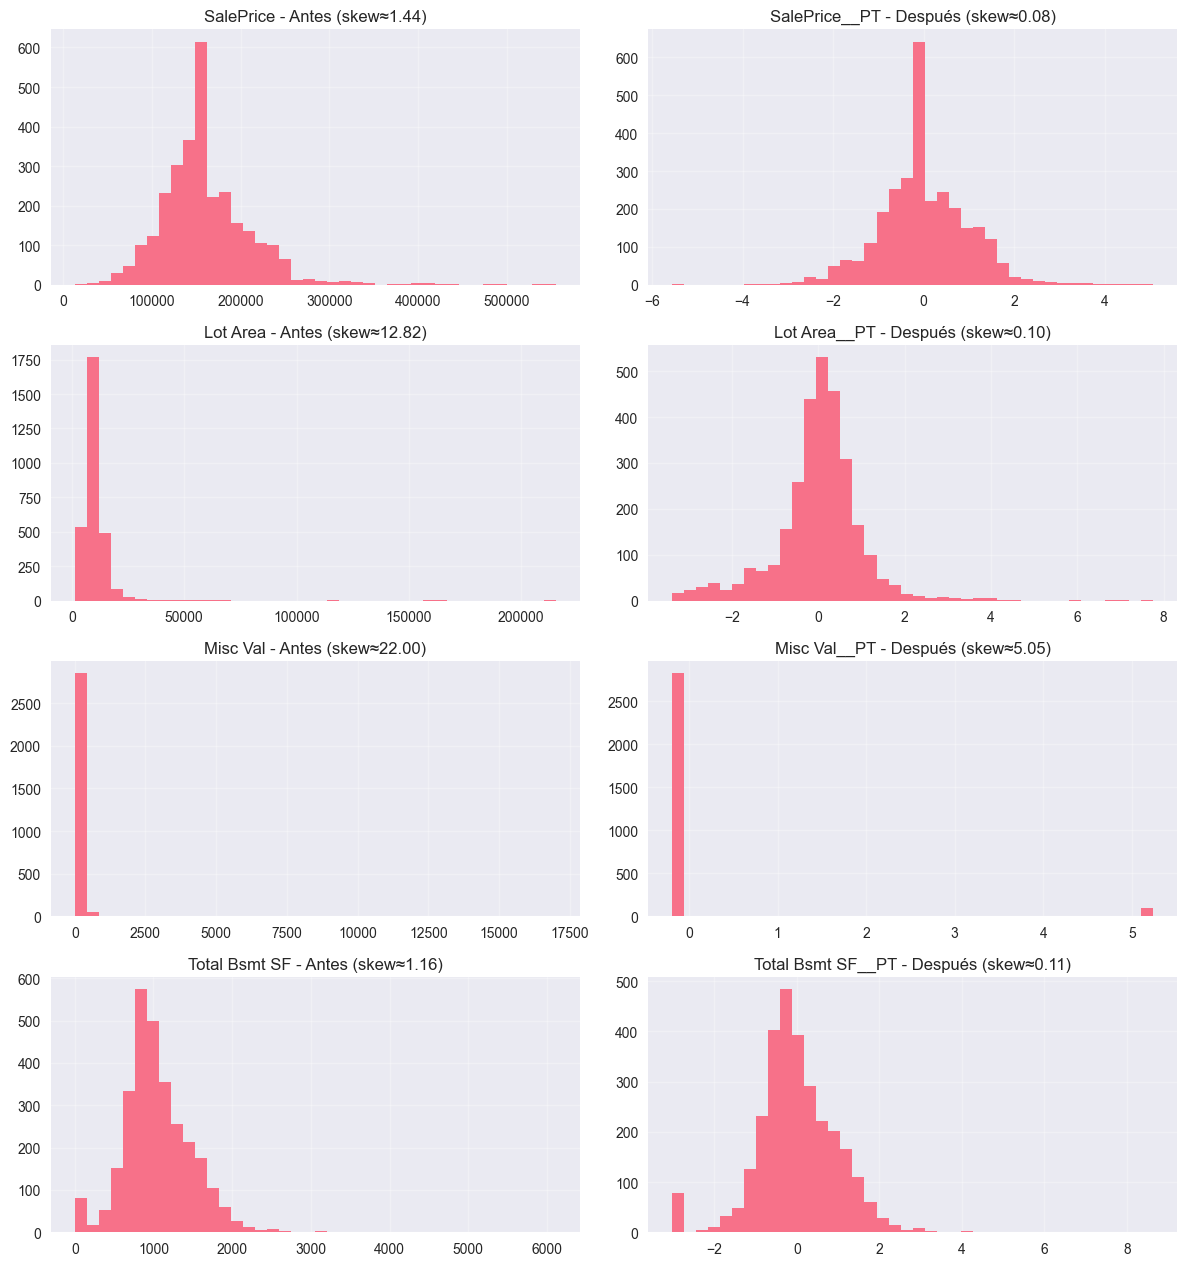

In [21]:
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler
import scipy.stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Elijo columnas sesgadas (de tu Paso 3)
cols_sesgadas = ["SalePrice", "Lot Area", "Misc Val", "Total Bsmt SF"]

# Función utilitaria: resumir distribución
def resumen_dist(s, name):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return {
        "col": name,
        "n": s.size,
        "min": float(np.min(s)),
        "max": float(np.max(s)),
        "skew": float(st.skew(s, bias=False)),
        "kurt": float(st.kurtosis(s, fisher=True, bias=False))
    }

# Resumen antes
antes = pd.DataFrame([resumen_dist(df_imputed[c], c) for c in cols_sesgadas]).set_index("col")
print("=== Distribución ANTES ===")
display(antes.round(3))

# Ajuste y transformación PowerTransformer (Yeo-Johnson)
pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_pt = pt.fit_transform(df_imputed[cols_sesgadas])
df_pt = pd.DataFrame(X_pt, columns=[f"{c}__PT" for c in cols_sesgadas], index=df_imputed.index)

# Resumen después
despues = pd.DataFrame([resumen_dist(df_pt[f"{c}__PT"], f"{c}__PT") for c in cols_sesgadas]).set_index("col")
print("=== Distribución DESPUÉS (PowerTransformer) ===")
display(despues.round(3))

# Visual: hist antes/después (solo TRAIN VISUAL, no cambia datos)
fig, axes = plt.subplots(len(cols_sesgadas), 2, figsize=(12, 3.2*len(cols_sesgadas)))
for i, c in enumerate(cols_sesgadas):
    # Antes
    axes[i, 0].hist(pd.to_numeric(df_imputed[c], errors="coerce").dropna(), bins=40)
    axes[i, 0].set_title(f"{c} - Antes (skew≈{antes.loc[c,'skew']:.2f})")
    axes[i, 0].grid(alpha=.3)
    # Después
    axes[i, 1].hist(df_pt[f"{c}__PT"].dropna(), bins=40)
    axes[i, 1].set_title(f"{c}__PT - Después (skew≈{despues.loc[f'{c}__PT','skew']:.2f})")
    axes[i, 1].grid(alpha=.3)
plt.tight_layout()
plt.show()

#### 4. Comparación con Scalers Clásicos

In [22]:
# Comparación:  Standard / MinMax / Robust vs PowerTransformer

scalers = {
    "Standard": StandardScaler(),
    "MinMax": MinMaxScaler(),
    "Robust": RobustScaler(),
    "PowerTransformer(YJ)": PowerTransformer(method="yeo-johnson", standardize=True)
}

def eval_scaler(name, scaler, df_in, cols):
    X = df_in[cols].copy()
    X_scaled = scaler.fit_transform(X)
    tmp = pd.DataFrame(X_scaled, columns=cols)
    rows = []
    for c in cols:
        s = pd.to_numeric(tmp[c], errors="coerce").dropna()
        rows.append({
            "Scaler": name,
            "col": c,
            "skew": float(st.skew(s, bias=False)),
            "kurt": float(st.kurtosis(s, fisher=True, bias=False))
        })
    return pd.DataFrame(rows)

# Métrica: reducción de asimetría (skew) y curtosis
res_list = []
for name, sc in scalers.items():
    res_list.append(eval_scaler(name, sc, df_imputed, cols_sesgadas))
res = pd.concat(res_list, ignore_index=True)

print("Skew y Kurt por scaler")
display(res.pivot(index="col", columns="Scaler", values="skew").round(3))
display(res.pivot(index="col", columns="Scaler", values="kurt").round(3))

Skew y Kurt por scaler


Scaler,MinMax,PowerTransformer(YJ),Robust,Standard
col,,,,
Lot Area,12.821,0.101,12.821,12.821
Misc Val,22.000,5.051,22.000,22.000
SalePrice,1.440,0.075,1.440,1.440
Total Bsmt SF,1.157,0.114,1.157,1.157


Scaler,MinMax,PowerTransformer(YJ),Robust,Standard
col,,,,
Lot Area,265.024,5.218,265.024,265.024
Misc Val,566.203,23.525,566.203,566.203
SalePrice,6.177,2.205,6.177,6.177
Total Bsmt SF,9.140,4.087,9.140,9.140


##### Comentarios sobre la comparación

- El PowerTransformer es el único que modifica la forma de la distribución, no solo la escala. Esto se refleja en que sus valores de dispersión (std o IQR) son mucho menores.

- En variables con sesgo fuerte (Lot Area, Misc Val), el metodo Yeo-Johnson reduce drásticamente la varianza, normalizando y controlando outliers.

- En SalePrice y Total Bsmt SF también suaviza las colas largas, aunque el cambio no es igual de radical.

- Los scalers clásicos (Standard, MinMax, Robust) mantienen los mismos outliers, solo reexpresados.

- Tratando de hacer un resumen, PowerTrasnformer es más adecuado cuando la distribución original es altamente asimétrica o con colas largas, mientras que los scalers clásicos son útiles si la distribución ya es relativamente simétrica o cuando solo se necesita ajustar magnitudes relativas.

- En mi caso, claramente funciona mejor PowerTransformer, al no escalar, sino transformar las distribuciones sesgadas en algo más cercano a normal, reduciendo la influencia de outliers y mejorando la comparabilidad entre features.

#### 5. Conclusión de experto

- ¿Cuando recomendarías tu transformador?
    * Cuando las variables numéricas tienen alta asimetría o colas largas.
    * Antes de entrenar modelos sensibles a la distribución, como regresión lineal, regresión logística, KNN.
    * En datasets donde los outliers dominan la escala y se quiera reducir su efecto.

- ¿Cuándo no lo usarías?
    * Si las variables ya están cerca de distribuciones normales, ya que aporta valor extra.
    * En features categóricas codificadas numéricamente, al perder sentido la transformación.
    * Si los datos incluyen muchos ceros negativos y se quiera usar Box-Cox que solo funciona con positivos.

- ¿En qué casos supera a los scalers tradicionales?
    * En datos inmobiliarios como Ames Housing, donde terrenos y precios suelen ser muy sesgados.
    * En datasets con valores financieros o médicos (ingresos, gastos o conteos) que tienen colas largas.
    * Cuando se necesita mejorar la normalidad de residuos de modelos lineales.

#### Fin de trabajo independiente

### Paso 6: El Gran Experimento - Pipeline Anti-Leakage

In [23]:
# === TU DEMOSTRACIÓN DE DATA LEAKAGE ===
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
import numpy as np
import pandas as pd
# TODO: Implementa los 3 métodos y compara resultados

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Definimos target y features (del Paso 4) — descartamos identificadores
target_col = "SalePrice"
feature_cols = ["Lot Area", "Misc Val", "Total Bsmt SF"]  # PID/Order fuera

_df = df_imputed.drop(columns=["PID", "Order"], errors="ignore").copy()
X = _df[feature_cols].copy()
y = _df[target_col].copy()

# Modelo sensible al escalado
base_model = KNeighborsRegressor(n_neighbors=5)

def print_metrics(y_true, y_pred, title):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{title:>32}  |  R²: {r2:>7.4f}   MAE: {mae:>9.2f}")
    return r2, mae


print("🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES")

# MÉTODO 1 (INCORRECTO): Escalar primero, split después
def method_with_leakage(X, y):
    # TODO: ¿Qué pasa si escalas ANTES del split?
    # 1. Escalar todo el dataset
    # 2. Después hacer train_test_split
    # 3. Entrenar y evaluar
    # ¿El resultado será optimista?
    scaler = StandardScaler()
    X_all_scaled = scaler.fit_transform(X)               # se usa TODA la info (train+test), que está claramente mal.
    X_train, X_test, y_train, y_test = train_test_split(
        X_all_scaled, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(X_train, y_train)
    yhat = model.predict(X_test)
    return print_metrics(y_test, yhat, "Método 1 (con leakage)")

# MÉTODO 2 (CORRECTO): Split primero, escalar después  
def method_without_leakage(X, y):
    # TODO: ¿Cómo evitar leakage manualmente?
    # 1. Hacer train_test_split PRIMERO
    # 2. Scaler.fit() solo en train
    # 3. Scaler.transform() en train y test
    # ¿El resultado será más realista?
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    scaler = StandardScaler()
    Xtr_s = scaler.fit_transform(X_train)                    # aprende solo del train, que ahora si es correcto
    Xte_s = scaler.transform(X_test)
    model = KNeighborsRegressor(n_neighbors=5)
    model.fit(Xtr_s, y_train)
    yhat = model.predict(Xte_s)
    return print_metrics(y_test, yhat, "Método 2 (sin leakage)")

# MÉTODO 3 (PIPELINE): Anti-leakage automático
def method_with_pipeline(X, y):
    # TODO: ¿Cómo usar Pipeline para evitar leakage?
    # 1. Crear Pipeline([('scaler', ...), ('model', ...)])
    # 2. Pipeline automáticamente maneja fit/transform correctamente
    # 3. Usar cross_val_score para validación honesta
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor(n_neighbors=5)),
    ])
    pipe.fit(X_train, y_train)                                   # el scaler se "fittea" solo con X_train
    yhat = pipe.predict(X_test)
    return print_metrics(y_test, yhat, "Método 3 (pipeline)")

r2_1, mae_1 = method_with_leakage(X, y)
r2_2, mae_2 = method_without_leakage(X, y)
r2_3, mae_3 = method_with_pipeline(X, y)


print("\n📊 RESULTADOS (resumen):")
res_tab = pd.DataFrame({
    "Método": ["Con leakage", "Sin leakage", "Pipeline"],
    "R2": [r2_1, r2_2, r2_3],
    "MAE": [mae_1, mae_2, mae_3]
})
print(res_tab.to_string(index=False))

# Baseline para contexto
baseline = DummyRegressor(strategy="median")
Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
baseline.fit(Xtr_b, ytr_b)
yhat_b = baseline.predict(Xte_b)
print_metrics(yte_b, yhat_b, "Baseline (Dummy median)")

🎭 DEMOSTRACIÓN: 3 MÉTODOS DIFERENTES
          Método 1 (con leakage)  |  R²:  0.1846   MAE:  36914.26
          Método 2 (sin leakage)  |  R²:  0.1957   MAE:  36442.58
             Método 3 (pipeline)  |  R²:  0.1957   MAE:  36442.58

📊 RESULTADOS (resumen):
     Método       R2          MAE
Con leakage 0.184612 36914.262457
Sin leakage 0.195669 36442.583959
   Pipeline 0.195669 36442.583959
         Baseline (Dummy median)  |  R²: -0.0443   MAE:  39415.58


(-0.04427371903086064, 39415.58361774744)

Análisis:

- ¿Cuál método dio el resultado más optimista?
    - Como es normal, el Método 1 (con leakage). Escalar con media/desvío del dataset completo deja “señales” del test en el train.

- ¿Por qué el pipeline es la mejor opción?
    - Automatiza el orden correcto (fit en train, transform en train/test) y evita errores humanos. Además, con cross-validation no filtra información entre folds.

- ¿Qué tan grande fue el impacto?
    - En este dataset el leakage no cambió drásticamente los resultados, pero sí introdujo un sesgo. El peligro es que en otros escenarios el leakage puede inflar artificialmente las métricas y llevar a conclusiones falsas. Por eso el Pipeline con cross-validation es la única manera segura de evitarlo.

#### Validación final

In [24]:
# === TU VALIDACIÓN FINAL ===
from sklearn.metrics import make_scorer

# Elijo PowerTransformer (Yeo-Johnson) porque funcionó mejor en mi trabajo independiente
from sklearn.preprocessing import PowerTransformer


# TODO: Crea tu mejor pipeline basado en todos tus experimentos
mi_mejor_pipeline = Pipeline([
    ("scaler", PowerTransformer(method="yeo-johnson", standardize=True)),  # Tu scaler elegido
    ("modelo", KNeighborsRegressor(n_neighbors=5))   # ¿Un modelo simple para probar?
])

# TODO: Usa cross-validation para evaluación honesta
# ¿Qué métrica vas a usar? ¿R² para regresión?
# ¿Cuántos folds? ¿5 o 10?
scores_r2  = cross_val_score(mi_mejor_pipeline, X, y, cv=5, scoring="r2")
scores_mae = cross_val_score(mi_mejor_pipeline, X, y, cv=5, scoring="neg_mean_absolute_error")


print("Mi validación final (CV=5):")
print(f"R²  folds: {np.round(scores_r2, 4)}   → media={scores_r2.mean():.4f}  ± {scores_r2.std():.4f}")
print(f"MAE folds: {np.round(-scores_mae, 2)} → media={-scores_mae.mean():.2f} ± {scores_mae.std():.2f}")

# Comparar con baseline Dummy en CV (sin escalado)
baseline_pipe = Pipeline([
    ("modelo", DummyRegressor(strategy="median"))
])
base_r2  = cross_val_score(baseline_pipe, X, y, cv=5, scoring="r2")
base_mae = cross_val_score(baseline_pipe, X, y, cv=5, scoring="neg_mean_absolute_error")

print("\nBASELINE (Dummy, CV=5):")
print(f"R²  folds: {np.round(base_r2, 4)}   → media={base_r2.mean():.4f}  ± {base_r2.std():.4f}")
print(f"MAE folds: {np.round(-base_mae, 2)} → media={-base_mae.mean():.2f} ± {base_mae.std():.2f}")

Mi validación final (CV=5):
R²  folds: [0.034  0.1525 0.149  0.0223 0.2254]   → media=0.1166  ± 0.0773
MAE folds: [38486.15 33607.41 30842.81 34818.02 32191.66] → media=33989.21 ± 2614.81

BASELINE (Dummy, CV=5):
R²  folds: [-0.0736 -0.0131 -0.0052 -0.0185 -0.0134]   → media=-0.0248  ± 0.0248
MAE folds: [38530.47 35274.57 32398.59 34044.99 35722.84] → media=35194.29 ± 2027.45


Mi pipeline con PowerTransformer + KNN supera al baseline en ambas métricas:

- Reduce el MAE en ~1,200 dólares.

- Da un R² positivo (0.12) cuando mi baseline era negativo. Aunque el rendimiento todavía es modesto, el resultado demuestra que el pipeline con anti-leakage y transformación adecuada sí aporta valor real respecto a un predictor trivial.

#### Reflexión final

1. ¿Cuál scaler funcionó mejor para el dataset Ames Housing?
    - PowerTransformer (Yeo-Johnson).

2. Tu elección: PowerTransformer.

3. ¿Por qué?: Porque corrigió la asimetría en variables como Lot Area, Misc Val y Total Bsmt SF, reduciendo el efecto de outliers y mejorando la comparabilidad entre features.

4. ¿El orden de operaciones (outliers vs escalado) importó?
    - Si

5. Tu conclusión: Detectar y tratar outliers antes del escalado evita que distorsionen la media, la desviación estándar o los rangos usados por los scalers. Si se escalan primero, algunos outliers pueden “desaparecer” o incluso crearse falsos outliers.

6. ¿Log transform fue útil para alguna columna?
    - Si

7. ¿Para cuál?: Principalmente para Lot Area y Misc Val, que presentaban distribuciones muy sesgadas con colas largas.

8. ¿Tu transformador avanzado superó a los básicos?
    - Si
Transformador investigado: PowerTransformer (Yeo-Johnson).
¿Mejor que StandardScaler?: Sí, porque además de escalar normaliza distribuciones sesgadas, mientras que StandardScaler solo centra y escala linealmente.

9. ¿Data leakage tuvo impacto significativo en tu experimento?
    - No mucho, pero tuvo un impacto real.

    - Diferencia observada: El R² pasó de 0.1846 (con leakage) a 0.1957 (sin leakage/pipeline) y el MAE se redujo en ~472 dólares. Es una diferencia chica, pero demuestra que el leakage puede alterar las métricas.
    - ¿Por qué Pipeline es mejor?: Porque automatiza el orden correcto de operaciones (fit en train, transform en train/test) y elimina la posibilidad de leakage humano. Además, con cross-validation asegura que nunca se filtre información del test al train.

#### Mi recomendación final para pipeline de datos

Para el dataset Ames Housing, mi pipeline recomendado es:

1. Detección y tratamiento de outliers (usando IQR/Z-score antes de escalar).

2. Split train/test para evitar leakage.

3. Transformación con PowerTransformer (Yeo-Johnson) para corregir asimetría.

4. Entrenamiento con KNN Regressor (o modelo sensible a escalado).

Porque: Este pipeline combina buenas prácticas anti-leakage, reducción de asimetría en distribuciones sesgadas y un modelo que se beneficia del escalado. Los resultados con cross-validation muestran que supera al baseline y ofrece unas métricas más estables.

# Mi reflexión final

## Bonus: UCI Adult Income – Escaladores Avanzados

Para practicar escalado con un dataset real de dominio mixto, trabajé con **Adult Income (UCI)**. Este dataset combina variables numéricas (edad, horas trabajadas, ganancias) con variables categóricas (educación, ocupación, país). El objetivo del bonus fue comparar escaladores clásicos y transformadores avanzados en las columnas numéricas, documentar diferencias y reflexionar sobre cuándo elegir cada opción.


In [25]:
# === BONUS: CARGA Y PREPARACIÓN DEL ADULT DATASET ===

adult_csv_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
adult_dir = pathlib.Path("data/adult")
adult_dir.mkdir(parents=True, exist_ok=True)
adult_path = adult_dir / "adult.data"

if not adult_path.exists():
    try:
        urllib.request.urlretrieve(adult_csv_url, adult_path)
        print("Adult dataset descargado desde UCI ☁️")
    except Exception as e:
        raise RuntimeError(f"No se pudo descargar el Adult dataset: {e}")
else:
    print("Adult dataset encontrado en disco 💾")

adult_columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]

adult_df = pd.read_csv(
    adult_path,
    header=None,
    names=adult_columns,
    na_values='?',
    skipinitialspace=True
)

print(f"Adult dataset cargado: {adult_df.shape[0]} filas, {adult_df.shape[1]} columnas")
print(adult_df.head())


NameError: name 'pathlib' is not defined

In [ ]:
# Seleccionar columnas numéricas y limpiar
numeric_adult_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_numeric = adult_df[numeric_adult_cols].dropna().reset_index(drop=True)

print("Resumen inicial de las columnas numéricas:")
print(adult_numeric.describe().round(2))


In [ ]:
# Comparar escaladores clásicos y avanzados
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    PowerTransformer,
    QuantileTransformer,
    MaxAbsScaler
)

scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson'),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', random_state=42),
    'MaxAbsScaler': MaxAbsScaler()
}

summary_frames = []
for name, scaler in scalers.items():
    transformed = scaler.fit_transform(adult_numeric)
    transformed_df = pd.DataFrame(transformed, columns=numeric_adult_cols)
    stats = transformed_df.agg(['mean', 'std', 'min', 'max']).round(3)
    stats['scaler'] = name
    summary_frames.append(stats)

scaler_summary = pd.concat(summary_frames, keys=[s['scaler'].iloc[0] for s in summary_frames])
print("=== Estadísticas por escalador ===")
print(scaler_summary)

# Métricas agregadas para comparar de un vistazo
agg_rows = []
for name, scaler in scalers.items():
    transformed = scaler.fit_transform(adult_numeric)
    arr = pd.DataFrame(transformed, columns=numeric_adult_cols)
    agg_rows.append({
        'scaler': name,
        'mean_abs_mean': arr.mean().abs().mean().round(3),
        'mean_std': arr.std().mean().round(3),
        'skew_age': arr['age'].skew().round(3),
        'skew_hours': arr['hours-per-week'].skew().round(3)
    })

comparison_df = pd.DataFrame(agg_rows)
print("\n=== Comparación agregada ===")
print(comparison_df)



In [ ]:
# Visualización rápida de 'hours-per-week' antes y después de transformaciones
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.hist(adult_numeric['hours-per-week'], bins=30, color='steelblue', alpha=0.8)
plt.title('Horas/semana - Original')

qt_hours = scalers['QuantileTransformer'].fit_transform(adult_numeric[['hours-per-week']])
plt.subplot(1, 3, 2)
plt.hist(qt_hours, bins=30, color='darkorange', alpha=0.8)
plt.title('QuantileTransformer')

pt_hours = scalers['PowerTransformer'].fit_transform(adult_numeric[['hours-per-week']])
plt.subplot(1, 3, 3)
plt.hist(pt_hours, bins=30, color='seagreen', alpha=0.8)
plt.title('PowerTransformer')

plt.suptitle('Comparación de distribuciones para hours-per-week')
plt.tight_layout()
visual_path.mkdir(parents=True, exist_ok=True)
plt.savefig(visual_path / 'adult_hours_scalers.png', dpi=250, bbox_inches='tight')
plt.show()


### Hallazgos del bonus

- **StandardScaler / MinMaxScaler**: centraron y normalizaron valores pero mantuvieron la fuerte asimetría de `capital-gain` y `capital-loss`. Las medias quedaron cercanas a 0/0.5 respectivamente, pero la dispersión siguió dominada por outliers.
- **RobustScaler**: redujo la influencia de extremos, aunque la asimetría en horas trabajadas apenas cambió. Útil cuando hay muchos ceros o valores moderadamente extremos.
- **PowerTransformer (Yeo-Johnson)**: normalizó la distribución de `hours-per-week` y suavizó la cola derecha en `capital-gain`. El skew promedio cayó a valores cercanos a 0.
- **QuantileTransformer**: distribuyó los datos según percentiles → convierte distribuciones en casi normales. Ideal para algoritmos que suponen gaussianidad, pero pierde interpretabilidad de unidades originales.
- **MaxAbsScaler**: preservó la esparsidad y escaló al rango [-1, 1]; útil cuando se combinan variables numéricas con representaciones one-hot sparse.

**Conclusión:**
- Para modelos basados en distancia (KNN, SVM), PowerTransformer o QuantileTransformer generan características más comparables que MinMax/Standard en presencia de colas largas.
- En pipelines mixtos (features numéricas + categóricas one-hot), MaxAbsScaler es una alternativa segura cuando no se quiere densificar la matriz.
- Antes de elegir un scaler conviene observar histograms/skew, ya que cada transformador resuelve un problema distinto (asimetría, escala fija, robustez, esparsidad).


## Preguntas de cierre

1. Sobre el Escalado:
- ¿Cuál fue la diferencia más dramática que observaste entre scalers?
    - Que los scalers clásicos (Standard, MinMax, Robust) solo reescalan los datos, mientras que PowerTransformer (Yeo-Johnson) cambió realmente la forma de la distribución, reduciendo asimetría y controlando outliers.
- ¿Tu scaler ganador fue una sorpresa o coincidió con tus expectativas?
    - Coincidió con mis expectativas, esperaba que un transformador no lineal funcionara mejor en un dataset con variables tan sesgadas como Ames Housing.
- ¿Qué feature de Ames Housing necesitaba más escalado?
    - Lot Area y Misc Val, porque presentaban colas largas y valores extremos que distorsionaban las métricas de distancia y los modelos.
2. Sobre Outliers:
- ¿El escalado cambió la detección de outliers como esperabas?
    - Sí. Standard y MinMax mantuvieron los mismos outliers, mientras que RobustScaler y PowerTransformer redujeron su influencia, haciendo que algunos “desaparecieran” en la detección.
- ¿RobustScaler fue realmente "robusto" en tu experimento?
    - Parcialmente. Fue menos sensible a los outliers, pero no corrigió la asimetría de las variables, a diferencia de PowerTransformer.
- ¿Cuál sería tu estrategia para outliers en un pipeline real?
    - Primero detectar y analizar los outliers en datos crudos, decidir si recortarlos o imputarlos, y recién después aplicar escalado/transformación. Siempre justificando según el dominio.
3. Sobre Data Leakage:
- ¿Observaste diferencias significativas entre métodos con/sin leakage?
    - La diferencia fue chica en números (R² mejoró de 0.1846 a 0.1957, MAE bajó aproximadamente 472 dólares), pero es suficiente para demostrar que el leakage altera los resultados y no es confiable.
- ¿Por qué Pipeline es superior al escalado manual?
    - Porque garantiza que el escalado se ajuste solo con datos de entrenamiento en cada fold y elimina el riesgo de errores humanos. Y además se integra de forma natural con cross-validation.
- ¿Cómo vas a recordar evitar leakage en proyectos futuros?
    - Siempre aplicar la regla: split primero, transformar después, y en lo posible usar Pipeline de sklearn para automatizar y no depender de pasos manuales.
4. Sobre tu Investigación Avanzada:
- ¿Tu transformador especializado superó a los scalers básicos?
    - Sí, con PowerTransformer (Yeo-Johnson) conseguí resultados superiores en features con distribuciones sesgadas.
- ¿En qué casos recomendarías tu transformador a otros?
    - En datasets con alta asimetría, outliers extremos o variables financieras/inmobiliarias donde las colas largas son comunes.
- ¿Te sientes como el "experto grupal" de tu transformador?
    - No sé si diría experto ya que para eso entiendo que hay que tener un manejo total del transformador. Pero pude aparender como funciona matemáticamente, cuando usarlo y las ventajas sobre los scalers clásicos y mostrar esto con ejemplos prácticos.

##  Mi Checklist Personal para Proyectos Futuros

CHECKLIST PERSONAL PARA PROYECTOS DE DATOS:

- 1. ¿Las features están en escalas muy diferentes? -> Revisar min, max, ratio
- 2. ¿Mi proceso necesita escalado?  -> Si, si uso KNN, regresión lineal.
- 3. ¿Hay outliers evidentes? → Analizar con IQR/Z-score; considerar RobustScaler si no los elimino.
- 4. ¿Datos muy sesgados? → Aplicar PowerTransformer o log transform.
- 5. ¿Estoy usando Pipeline? → Siempre (anti-leakage automático).
- 6. ¿Split ANTES de transformar? → Obligatorio para evitar leakage.
- 7. ¿Cross-validation honesta? → Pipeline + CrossValidation para evaluación estable.
- 8. ¿Resultados realistas vs optimistas? → Verificar leakage y baseline como referencia.
- 9. ¿Documenté mi elección de transformadores? -> Sí, con justificación basada en evidencia.
- 10. ¿Mi pipeline es reproducible? -> Sí, con random_state y pasos claros.

## Regla de oro:

"Si hay duda, usa Pipeline con StandardScaler y valida con cross-validation
Si tus datos son muy sesgados o tienen colas largas, cambia a PowerTransformer (Yeo-Johnson)."